<a href="https://colab.research.google.com/github/Basa0006/Data-Science/blob/main/NHLPlayerCategorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning: Player Categorizer


##What NHL Teams Need at the Trade Deadline: Insights from HC Clusters and Data Analysis

### Context

As the NHL trade deadline approaches, teams across the league are evaluating their rosters and identifying areas for improvement to enhance their chances of making a deep playoff run. By leveraging HC clusters and data analysis, we can gain a comprehensive understanding of each team’s specific needs.

### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

First, we extract basic player stats from the NHL database, focusing exclusively on forwards and defensemen. The available data includes:

Player ID

Headshot

First Name

Last Name

Position Code

Games Played

Goals

Assists

Points

Plus/Minus

Penalty Minutes

Power Play Goals

Shorthanded Goals

Game-Winning Goals

Overtime Goals

Shots

Shooting Percentage

## Importing necessary libraries and data

In [ ]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to compute distances
from scipy.spatial.distance import cdist

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [ ]:
#Loading the dataset

from google.colab import files
import io

try:
    uploaded
except NameError:
    uploaded = files.upload()

playerdata = pd.read_csv(io.BytesIO(uploaded['NHL_stats2425.csv']))

Saving NHL_stats2425.csv to NHL_stats2425.csv


#Feature Engineering

Feature engineering involves creating new metrics from raw data to improve predictive modeling and analysis. The following hockey-related features help quantify player performance by normalizing key statistics over time and shifts:



* Goals per Time
*Assists per Time
*Shots per Time
*Penalty Minutes per Time


These engineered features normalize raw statistics (such as goals and assists)
based on time or shifts, allowing for fair comparisons across players with different amounts of playing time.

In [ ]:
#Feature Engineering

playerdata['goalsPerTime'] = (playerdata['goals'] / playerdata['avgTimeOnIcePerGame'])
playerdata['assistsPerTime'] = (playerdata['assists'] / playerdata['avgTimeOnIcePerGame'])
playerdata['shotsPerTime'] = (playerdata['shots'] / playerdata['avgTimeOnIcePerGame'])
playerdata['penaltyminutespertime'] = (playerdata['penaltyMinutes'] / playerdata['avgTimeOnIcePerGame'])
#playerdata['hitsPerTime'] = playerdata['hits'] / playerdata['avgTimeOnIcePerGame']
#playerdata['blockedPerTime'] = playerdata['blocked'] / playerdata['avgTimeOnIcePerGame']

## Data Overview

- Observations
- Sanity checks

In [ ]:
playerdata.head()

playerId                                           headshot  \
0   8475233  https://assets.nhle.com/mugs/nhl/20242025/MTL/...   
1   8475848  https://assets.nhle.com/mugs/nhl/20242025/MTL/...   
2   8476469  https://assets.nhle.com/mugs/nhl/20242025/MTL/...   
3   8476875  https://assets.nhle.com/mugs/nhl/20242025/MTL/...   
4   8476981  https://assets.nhle.com/mugs/nhl/20242025/MTL/...   

                firstName                  lastName positionCode  gamesPlayed  \
0    {'default': 'David'}     {'default': 'Savard'}            D           49   
1  {'default': 'Brendan'}  {'default': 'Gallagher'}            R           55   
2     {'default': 'Joel'}      {'default': 'Armia'}            R           55   
3     {'default': 'Mike'}   {'default': 'Matheson'}            D           53   
4     {'default': 'Josh'}   {'default': 'Anderson'}            R           55   

   goals  assists  points  plusMinus  penaltyMinutes  powerPlayGoals  \
0      1        9      10         -7              26               0   
1     12        9      21        -13              25               4   
2     10       14      24          1              16               0   
3      4       20      24         -9              41               1   
4      8       10      18        -10              56               0   

   shorthandedGoals  gameWinningGoals  overtimeGoals  shots  shootingPctg  \
0                 0                 0              0     34      0.029412   
1                 0                 1              0    101      0.118812   
2                 3                 1              0     82      0.121951   
3                 0                 0              0     99      0.040404   
4                 1                 0              0     73      0.109589   

   avgTimeOnIcePerGame  avgShiftsPerGame  faceoffWinPctg  goalsPerTime  \
0            1069.7551           20.8980        0.000000      0.000935   
1             822.2545           17.5455        0.000000      0.014594   
2             882.7273           17.8727        0.181818      0.011329   
3            1479.2075           25.0755        0.000000      0.002704   
4             848.3273           18.7091        0.617647      0.009430   

   assistsPerTime  shotsPerTime  penaltyminutespertime  
0        0.008413      0.031783               0.024305  
1        0.010946      0.122833               0.030404  
2        0.015860      0.092894               0.018126  
3        0.013521      0.066928               0.027718  
4        0.011788      0.086052               0.066012

In [ ]:
playerdata.tail()

playerId                                           headshot  \
845   8481607  https://assets.nhle.com/mugs/nhl/20242025/DET/...   
846   8481725  https://assets.nhle.com/mugs/nhl/20242025/DET/...   
847   8482078  https://assets.nhle.com/mugs/nhl/20242025/DET/...   
848   8482762  https://assets.nhle.com/mugs/nhl/20242025/DET/...   
849   8483464  https://assets.nhle.com/mugs/nhl/20242025/DET/...   

                 firstName                                     lastName  \
845  {'default': 'Albert'}                     {'default': 'Johansson'}   
846   {'default': 'Elmer'}  {'default': 'Soderblom', 'sv': 'Söderblom'}   
847   {'default': 'Lucas'}                       {'default': 'Raymond'}   
848   {'default': 'Simon'}                     {'default': 'Edvinsson'}   
849   {'default': 'Marco'}                        {'default': 'Kasper'}   

    positionCode  gamesPlayed  goals  assists  points  plusMinus  \
845            D           34      1        4       5         -3   
846            L            9      2        3       5          1   
847            L           55     21       38      59         -2   
848            D           51      5       16      21         11   
849            C           50      9       11      20         -7   

     penaltyMinutes  powerPlayGoals  shorthandedGoals  gameWinningGoals  \
845               8               0                 0                 1   
846               0               0                 0                 1   
847              16               5                 1                 3   
848              34               0                 0                 2   
849              20               2                 0                 1   

     overtimeGoals  shots  shootingPctg  avgTimeOnIcePerGame  \
845              0     26      0.038462             948.2647   
846              0     13      0.153846             765.3333   
847              1    129      0.162791            1136.8182   
848              1     51      0.098039            1248.5294   
849              0     82      0.109756             877.2400   

     avgShiftsPerGame  faceoffWinPctg  goalsPerTime  assistsPerTime  \
845           20.9412        0.000000      0.001055        0.004218   
846           17.2222        0.400000      0.002613        0.003920   
847           22.7455        0.000000      0.018473        0.033427   
848           24.6275        0.000000      0.004005        0.012815   
849           19.2000        0.474432      0.010259        0.012539   

     shotsPerTime  penaltyminutespertime  
845      0.027419               0.008436  
846      0.016986               0.000000  
847      0.113475               0.014074  
848      0.040848               0.027232  
849      0.093475               0.022799

In [ ]:
# viewing a random sample of the dataset
playerdata.sample(n=10, random_state=1)

playerId                                           headshot  \
486   8484258  https://assets.nhle.com/mugs/nhl/20242025/COL/...   
559   8483445  https://assets.nhle.com/mugs/nhl/20242025/ANA/...   
185   8482113  https://assets.nhle.com/mugs/nhl/20242025/FLA/...   
806   8476882  https://assets.nhle.com/mugs/nhl/20242025/CHI/...   
493   8476826  https://assets.nhle.com/mugs/nhl/20242025/SEA/...   
298   8475167  https://assets.nhle.com/mugs/nhl/20242025/TBL/...   
842   8480813  https://assets.nhle.com/mugs/nhl/20242025/DET/...   
776   8483505  https://assets.nhle.com/mugs/nhl/20242025/BOS/...   
752   8477507  https://assets.nhle.com/mugs/nhl/20242025/BOS/...   
755   8477956  https://assets.nhle.com/mugs/nhl/20242025/BOS/...   

                                             firstName  \
486                                 {'default': 'Sam'}   
559                              {'default': 'Cutter'}   
185                               {'default': 'Anton'}   
806                               {'default': 'Teuvo'}   
493                               {'default': 'Yanni'}   
298                              {'default': 'Victor'}   
842  {'default': 'Joe', 'cs': 'Joseph', 'de': 'Jose...   
776                             {'default': 'Matthew'}   
752                              {'default': 'Nikita'}   
755                               {'default': 'David'}   

                                              lastName positionCode  \
486                            {'default': 'Malinski'}            D   
559                            {'default': 'Gauthier'}            L   
185                             {'default': 'Lundell'}            C   
806  {'default': 'Teravainen', 'cs': 'Teräväinen', ...            C   
493                              {'default': 'Gourde'}            C   
298                              {'default': 'Hedman'}            D   
842                              {'default': 'Veleno'}            C   
776                             {'default': 'Poitras'}            C   
752                             {'default': 'Zadorov'}            D   
755  {'default': 'Pastrnak', 'cs': 'Pastrňák', 'sk'...            R   

     gamesPlayed  goals  assists  points  plusMinus  penaltyMinutes  \
486           54      1        5       6          1               6   
559           54      9       13      22          0              14   
185           56     13       23      36         10              24   
806           55     12       28      40        -15               6   
493           35      6       10      16         -5              36   
298           52      7       35      42          8              24   
842           50      5        5      10        -12              13   
776           26      1       10      11         -3               6   
752           57      3       11      14         16             117   
755           57     28       40      68          0              30   

     powerPlayGoals  shorthandedGoals  gameWinningGoals  overtimeGoals  shots  \
486               0                 0                 0              0     71   
559               2                 0                 2              1    113   
185               2                 2                 1              0    114   
806               5                 0                 0              0     84   
493               0                 0                 1              0     38   
298               1                 0                 1              0    123   
842               0                 0                 0              0     43   
776               0                 0                 1              0     23   
752               0                 0                 0              0     76   
755               6                 0                 4              3    230   

     shootingPctg  avgTimeOnIcePerGame  avgShiftsPerGame  faceoffWinPctg  \
486      0.014085             927.7037           20.0185        0.000000   
559      

In [ ]:
playerdata.shape

(850, 24)

##Observations
-850 records

-24 columns

In [ ]:
playerdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   playerId               850 non-null    int64  
 1   headshot               850 non-null    object 
 2   firstName              850 non-null    object 
 3   lastName               850 non-null    object 
 4   positionCode           850 non-null    object 
 5   gamesPlayed            850 non-null    int64  
 6   goals                  850 non-null    int64  
 7   assists                850 non-null    int64  
 8   points                 850 non-null    int64  
 9   plusMinus              850 non-null    int64  
 10  penaltyMinutes         850 non-null    int64  
 11  powerPlayGoals         850 non-null    int64  
 12  shorthandedGoals       850 non-null    int64  
 13  gameWinningGoals       850 non-null    int64  
 14  overtimeGoals          850 non-null    int64  
 15  shots 

##Observations
-All records have data in them

-three data types: Object, float, and integer

In [ ]:
playerdata.describe().T

count          mean          std        min  \
playerId               850.0  8.479316e+06  2837.920650  8470600.0   
gamesPlayed            850.0  3.755294e+01    19.266530        1.0   
goals                  850.0  6.228235e+00     6.896315        0.0   
assists                850.0  1.047529e+01    10.391737        0.0   
points                 850.0  1.670353e+01    16.153755        0.0   
plusMinus              850.0 -4.129412e-01     8.725095      -28.0   
penaltyMinutes         850.0  1.652000e+01    15.739418        0.0   
powerPlayGoals         850.0  1.223529e+00     2.291874        0.0   
shorthandedGoals       850.0  1.600000e-01     0.499988        0.0   
gameWinningGoals       850.0  9.905882e-01     1.482495        0.0   
overtimeGoals          850.0  1.564706e-01     0.485587        0.0   
shots                  850.0  5.945765e+01    47.262904        0.0   
shootingPctg           850.0  8.541387e-02     0.082448        0.0   
avgTimeOnIcePerGame    850.0  9.135634e+02   265.438790      311.0   
avgShiftsPerGame       850.0  1.944855e+01     4.599216        7.0   
faceoffWinPctg         850.0  2.478410e-01     0.254472        0.0   
goalsPerTime           850.0  6.233876e-03     0.006358        0.0   
assistsPerTime         850.0  1.004034e-02     0.008571        0.0   
shotsPerTime           850.0  5.972874e-02     0.041364        0.0   
penaltyminutespertime  850.0  1.802453e-02     0.018467        0.0   

                                25%           50%           75%           max  
playerId               8.477366e+06  8.479388e+06  8.481600e+06  8.485105e+06  
gamesPlayed            2.100000e+01  4.700000e+01  5.400000e+01  5.800000e+01  
goals                  1.000000e+00  4.000000e+00  1.000000e+01  4.000000e+01  
assists                2.000000e+00  8.000000e+00  1.600000e+01  6.600000e+01  
points                 3.250000e+00  1.300000e+01  2.500000e+01  8.700000e+01  
plusMinus             -5.000000e+00 -1.000000e+00  3.000000e+00  3.100000e+01  
penaltyMinutes         6.000000e+00  1.200000e+01  2.300000e+01  1.170000e+02  
powerPlayGoals         0.000000e+00  0.000000e+00  1.000000e+00  1.300000e+01  
shorthandedGoals       0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00  
gameWinningGoals       0.000000e+00  0.000000e+00  1.000000e+00  9.000000e+00  
overtimeGoals          0.000000e+00  0.000000e+00  0.000000e+00  4.000000e+00  
shots                  1.800000e+01  5.400000e+01  9.175000e+01  2.340000e+02  
shootingPctg           3.013200e-02  7.692300e-02  1.250000e-01  1.000000e+00  
avgTimeOnIcePerGame    7.088893e+02  9.103588e+02  1.110594e+03  1.617000e+03  
avgShiftsPerGame       1.625160e+01  1.962360e+01  2.256945e+01  3.207270e+01  
faceoffWinPctg         0.000000e+00  2.472220e-01  4.753358e-01  1.000000e+00  
goalsPerTime           1.057376e-03  4.037183e-03  1.053051e-02  3.065177e-02  
assistsPerTime         3.128027e-03  8.841646e-03  1.486789e-02  4.771811e-02  
shotsPerTime           2.368515e-02  5.656763e-02  8.920512e-02  2.095400e-01  
penaltyminutespertime  5.869789e-03  1.343348e-02  2.372268e-02  1.339076e-01

In [ ]:
playerdata.duplicated().sum()

0

In [ ]:
playerdata.isna().sum()

playerId                 0
headshot                 0
firstName                0
lastName                 0
positionCode             0
gamesPlayed              0
goals                    0
assists                  0
points                   0
plusMinus                0
penaltyMinutes           0
powerPlayGoals           0
shorthandedGoals         0
gameWinningGoals         0
overtimeGoals            0
shots                    0
shootingPctg             0
avgTimeOnIcePerGame      0
avgShiftsPerGame         0
faceoffWinPctg           0
goalsPerTime             0
assistsPerTime           0
shotsPerTime             0
penaltyminutespertime    0
dtype: int64

#No Duplicate values

## Exploratory Data Analysis (EDA)


###Univariate Analysis

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue = feature,
        palette="Paired",
        legend=False,
        order=data[feature].value_counts().index[:n].sort_values(),
    )


    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

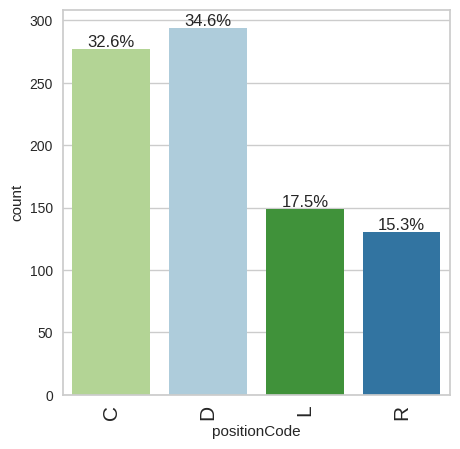

In [ ]:
labeled_barplot(playerdata, "positionCode", perc=True)

**Observations**

- Approx. 34.6% of the players are defenseman.  This is in line with expectations considering most teams carry 6 defenseman on a team of 20.
- 32.6% are centers which is counter intuitive to what you would expect, 4 out of 20.  Seams like some wingers are being labeled centers in the data.

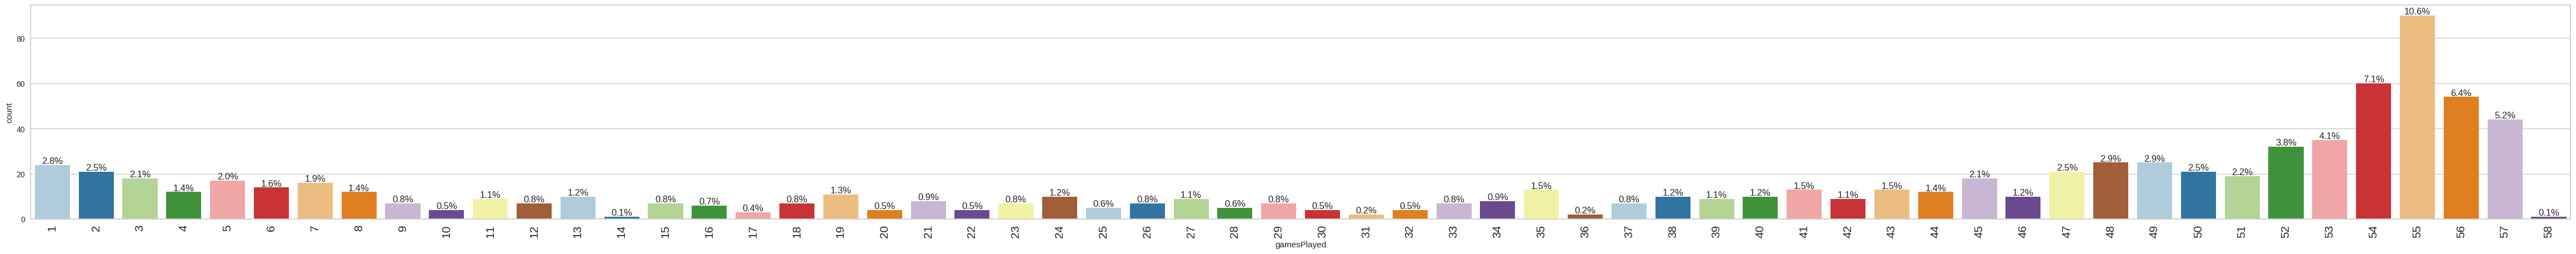

In [ ]:
labeled_barplot(playerdata, "gamesPlayed", perc=True)

##Observations from games played
-About 30% of players have played 50 games or more in 2025 season


In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

**`Shots`**

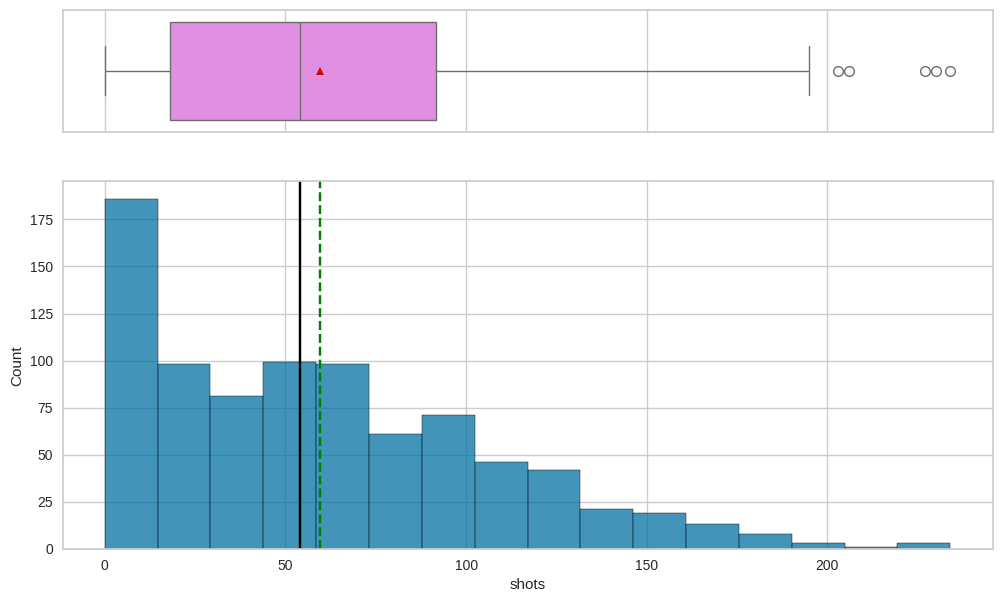

In [ ]:
histogram_boxplot(playerdata, 'shots')

##Observation
-Data is skewed left

-not normally distributed
  
-There are few outliers

**'Shifts Per Game'**

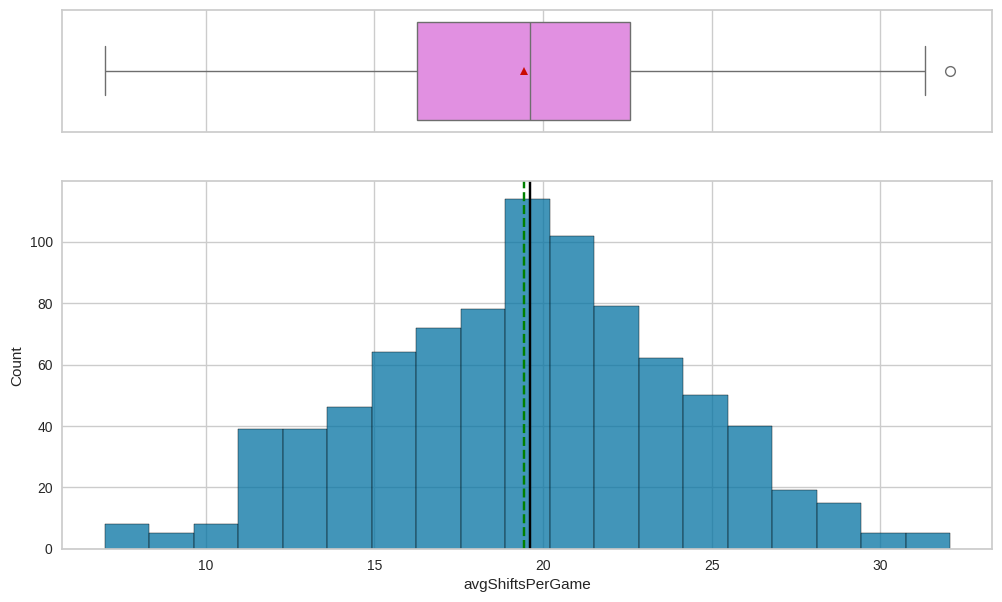

In [ ]:
histogram_boxplot(playerdata, 'avgShiftsPerGame')

##Observations
-Close to normally distributed



**'Goals per Time on Ice'**

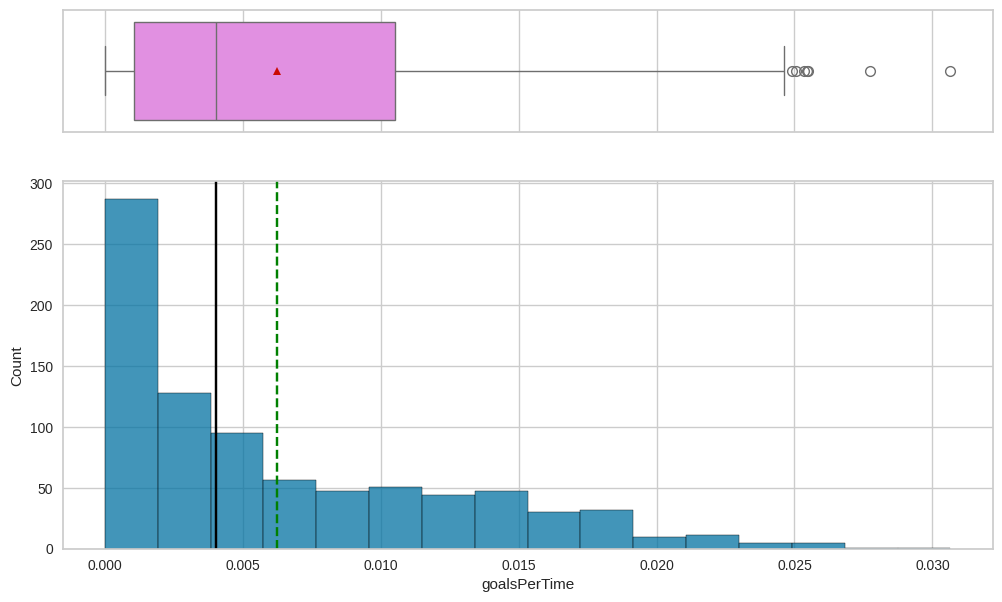

In [ ]:
histogram_boxplot(playerdata, 'goalsPerTime')

##Observations
-Data is skewed left

-Outliers to the right

**'Plus/Minus'**

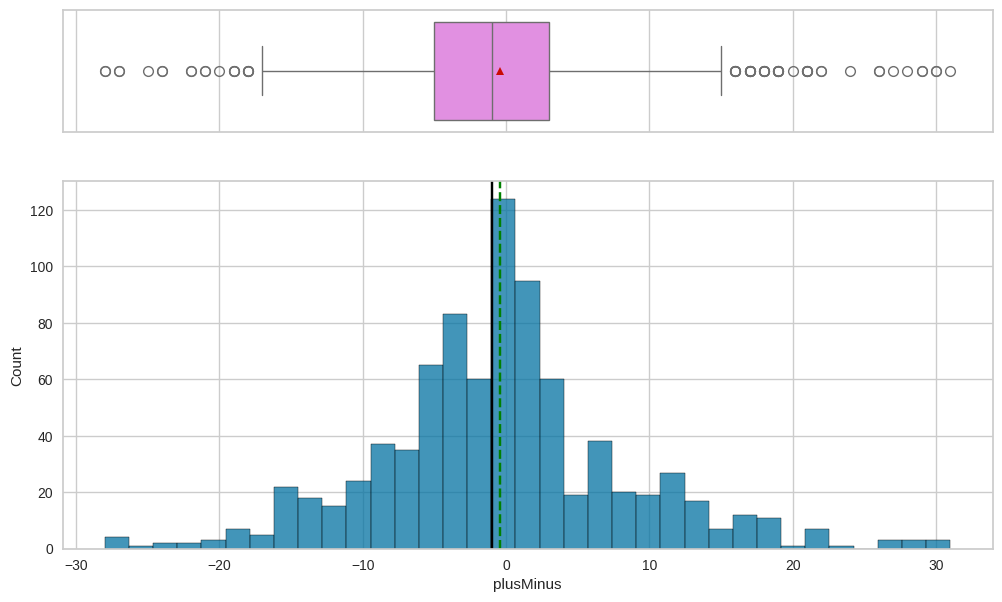

In [ ]:
histogram_boxplot(playerdata, 'plusMinus')

##Observations
-Close to Normal Distribution

-outliers on both sides

**'Penalty Minutes'**

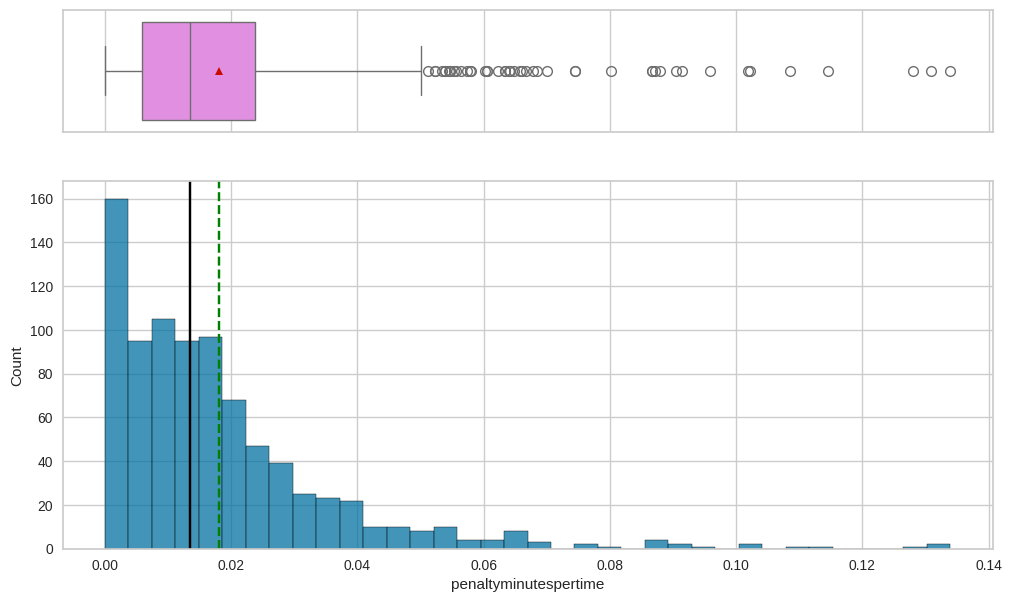

In [ ]:
histogram_boxplot(playerdata, 'penaltyminutespertime')

##Observations
-Skewed left

-Outliers to the right

**'Time on Ice'**

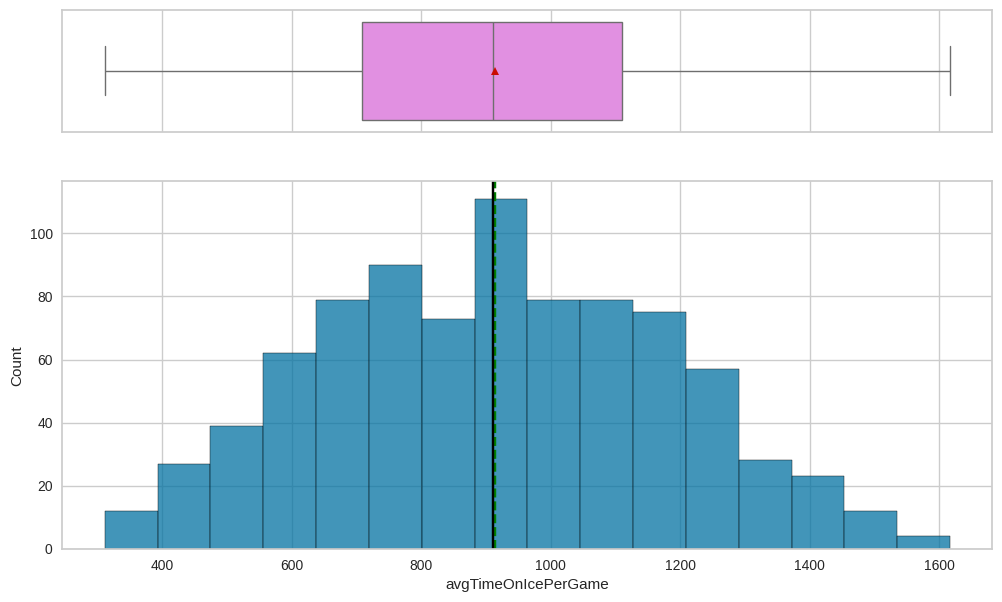

In [ ]:
histogram_boxplot(playerdata, 'avgTimeOnIcePerGame')

##Observations
-Close to normally distributed

-No outliers

###Bivariate Analysis

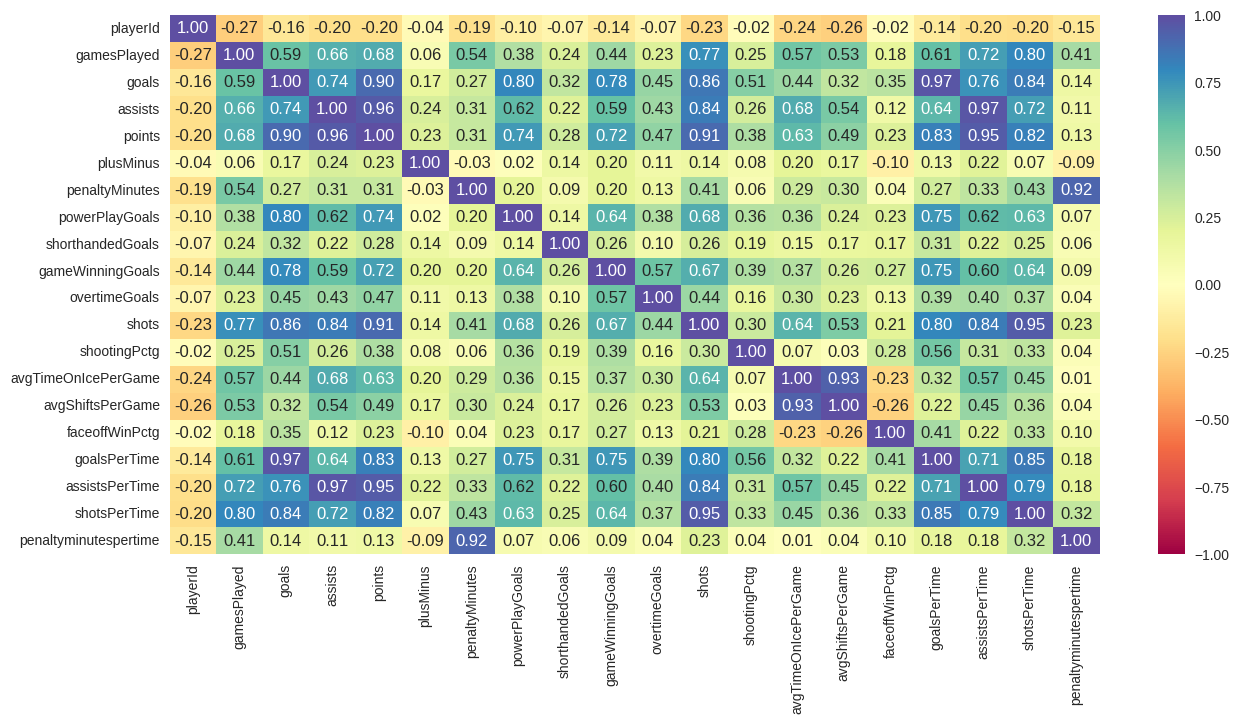

In [ ]:
#need to remove strings to work
# correlation check
numeric_columns = playerdata.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 7))
sns.heatmap(
    #stockdata.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
    playerdata[numeric_columns].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.savefig("Bivariate_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()



##Observations
Empirical evidence confirms that shooting the puck leads to points — an observation that cannot be overstated. Additionally, some feature engineering adjustments may have overridden certain stats, making some data redundant. While all stats and engineered features were retained for this model, some could be omitted in future iterations to improve efficiency and comprehension.

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

### Outlier Check

- Plot the boxplots of all numerical columns to check for outliers.

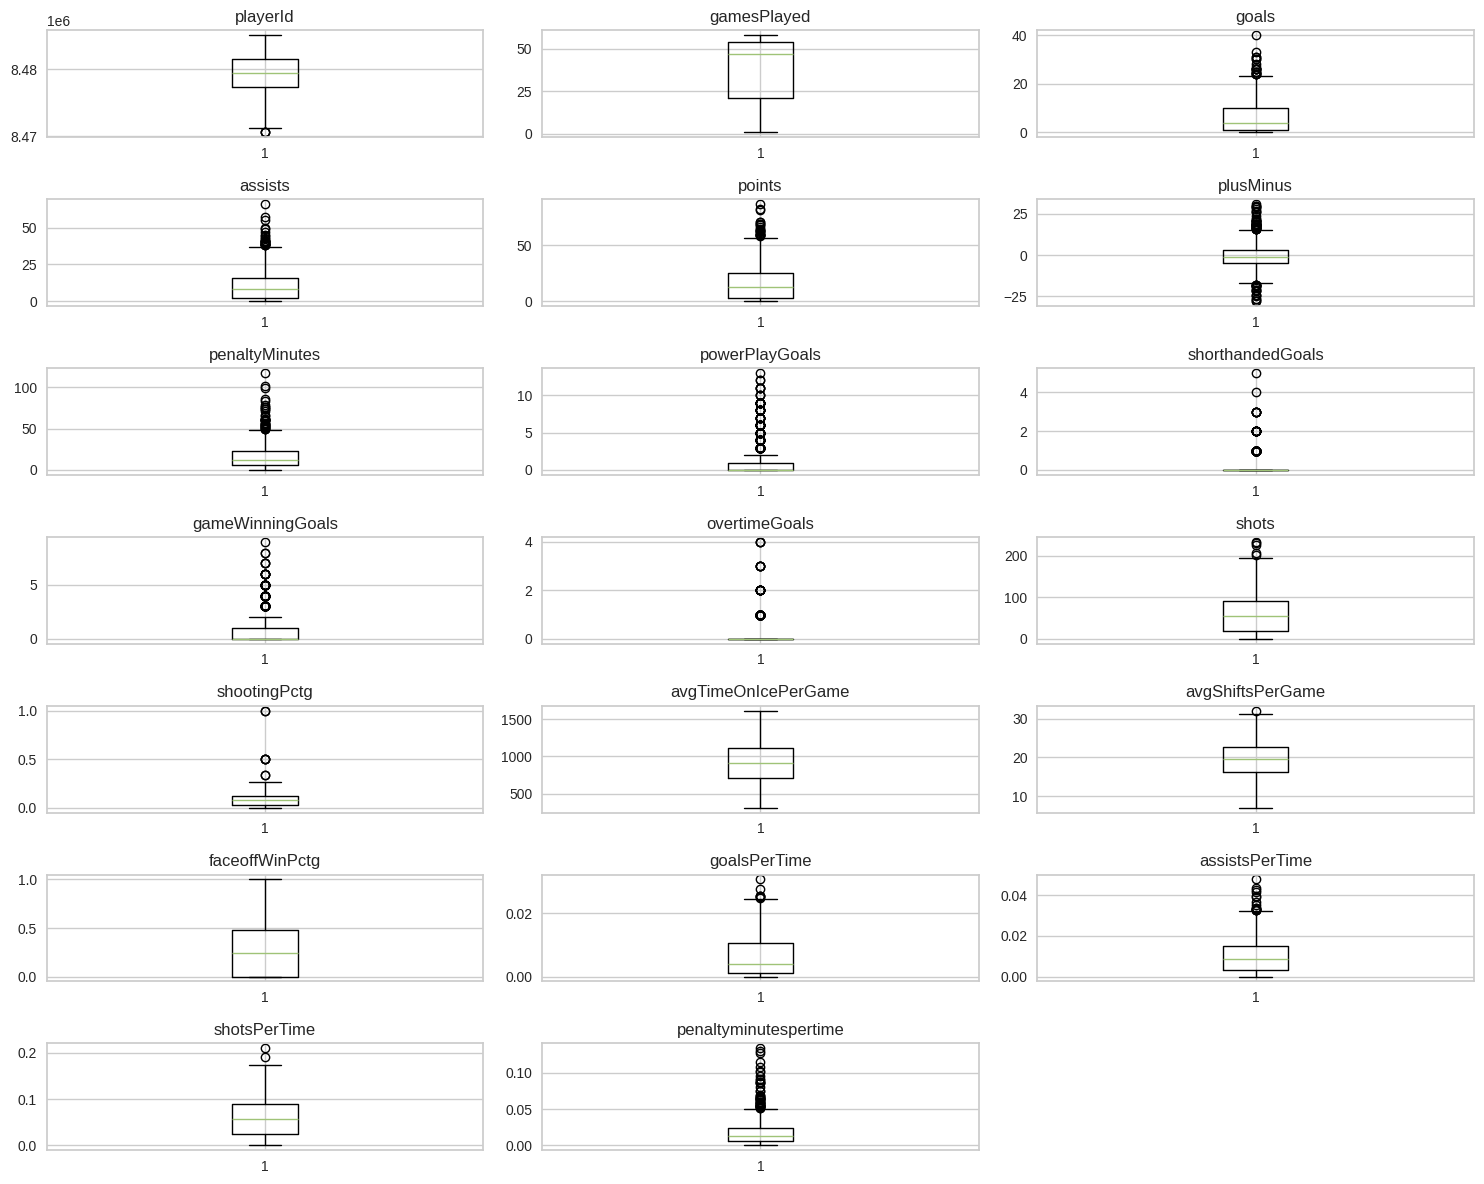

In [ ]:
plt.figure(figsize=(15, 12))

#numeric_columns = playerdata.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(numeric_columns):
    plt.subplot(7, 3, i + 1)
    plt.boxplot(playerdata[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

##Observations
-All numerical columns have outliers, however, we are going to leave them as they are assumed to be accurate.

In [ ]:
# copying the data to another variable to avoid any changes to original data
df = playerdata.copy()

#Drop the following columns as they provide no data
# 1   headshot             26 non-null     object
#20  firstName.cs         2 non-null      object
# 21  firstName.de         1 non-null      object
# 22  firstName.es         1 non-null      object
# 23  firstName.fi         2 non-null      object
# 24  firstName.sk         2 non-null      object
# 25  firstName.sv         1 non-null      object
# 26  lastName.cs          2 non-null      object
# 27  lastName.fi          2 non-null      object
# 28  lastName.sk          2 non-null      object
# 29  lastName.sv          1 non-null      object


df.drop("headshot", axis=1, inplace=True)
#df.drop("firstName.cs", axis=1, inplace=True)
#df.drop("firstName.de", axis=1, inplace=True)
#df.drop("firstName.es", axis=1, inplace=True)
#df.drop("firstName.fi", axis=1, inplace=True)
#df.drop("firstName.sk", axis=1, inplace=True)
#df.drop("firstName.sv", axis=1, inplace=True)
#df.drop("lastName.cs", axis=1, inplace=True)
#df.drop("lastName.de", axis=1, inplace=True)
#df.drop("lastName.es", axis=1, inplace=True)
#df.drop("lastName.fi", axis=1, inplace=True)
#df.drop("lastName.sk", axis=1, inplace=True)
#df.drop("lastName.sv", axis=1, inplace=True)

df

playerId               firstName  \
0     8475233    {'default': 'David'}   
1     8475848  {'default': 'Brendan'}   
2     8476469     {'default': 'Joel'}   
3     8476875     {'default': 'Mike'}   
4     8476981     {'default': 'Josh'}   
..        ...                     ...   
845   8481607   {'default': 'Albert'}   
846   8481725    {'default': 'Elmer'}   
847   8482078    {'default': 'Lucas'}   
848   8482762    {'default': 'Simon'}   
849   8483464    {'default': 'Marco'}   

                                        lastName positionCode  gamesPlayed  \
0                          {'default': 'Savard'}            D           49   
1                       {'default': 'Gallagher'}            R           55   
2                           {'default': 'Armia'}            R           55   
3                        {'default': 'Matheson'}            D           53   
4                        {'default': 'Anderson'}            R           55   
..                                           ...          ...          ...   
845                     {'default': 'Johansson'}            D           34   
846  {'default': 'Soderblom', 'sv': 'Söderblom'}            L            9   
847                       {'default': 'Raymond'}            L           55   
848                     {'default': 'Edvinsson'}            D           51   
849                        {'default': 'Kasper'}            C           50   

     goals  assists  points  plusMinus  penaltyMinutes  powerPlayGoals  \
0        1        9      10         -7              26               0   
1       12        9      21        -13              25               4   
2       10       14      24          1              16               0   
3        4       20      24         -9              41               1   
4        8       10      18        -10              56               0   
..     ...      ...     ...        ...             ...             ...   
845      1        4       5         -3               8               0   
846      2        3       5          1               0               0   
847     21       38      59         -2              16               5   
848      5       16      21         11              34               0   
849      9       11      20         -7              20               2   

     shorthandedGoals  gameWinningGoals  overtimeGoals  shots  shootingPctg  \
0                   0                 0              0     34      0.029412   
1                   0                 1              0    101      0.118812   
2                   3                 1              0     82      0.121951   
3                   0                 0              0     99      0.040404   
4                   1                 0              0     73      0.109589   
..                ...               ...            ...    ...           ...   
845                 0                 1              0     26      0.038462   
846                 0                 1              0     13      0.153846   
847                 1                 3              1    129      0.162791   
848                 0                 2              1     51      0.098039   
849                 0                 1              0     82      0.109756   

     avgTimeOnIcePerGame  avgShiftsPerGame  faceoffWinPctg  goalsPerTime  \
0              1069.7551           20.8980        0.000000      0.000935   
1               822.2545           17.5455        0.000000      0.014594   
2               882.7273           17.8727        0.181818      0.011329   
3              1479.2075           25.0755        0.000000      0.002704   
4               848.3273           18.7091        0.617647      0.009430   
..                   ...               ...             ...           ...   
845             948.2647           20.9412        0.000000      0.001055   
846             765.3333           17.2222        0.400000      0.002613   
847            1136.8182           22.7455        0.0

### Scaling

- Scale the data in preparation for clustering.

In [ ]:
# Scaling the data set before clustering
scaler = StandardScaler()
#subset = df[num_col].copy()
subset = df[numeric_columns].copy()
subset_scaled = scaler.fit_transform(subset)


In [ ]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

In [ ]:
k_means_df = subset_scaled_df.copy()

Number of Clusters: 1 	Average Distortion: 4.155356471833391
Number of Clusters: 2 	Average Distortion: 3.4625692344715513
Number of Clusters: 3 	Average Distortion: 3.1432493602197016
Number of Clusters: 4 	Average Distortion: 2.963484612480357
Number of Clusters: 5 	Average Distortion: 2.9124925436330242
Number of Clusters: 6 	Average Distortion: 2.8320645348233646
Number of Clusters: 7 	Average Distortion: 2.711471232042739
Number of Clusters: 8 	Average Distortion: 2.7119479162168676
Number of Clusters: 9 	Average Distortion: 2.612152270872971
Number of Clusters: 10 	Average Distortion: 2.5728488320565632
Number of Clusters: 11 	Average Distortion: 2.534280648134933
Number of Clusters: 12 	Average Distortion: 2.4803590081245352
Number of Clusters: 13 	Average Distortion: 2.4802506021616004
Number of Clusters: 14 	Average Distortion: 2.42935487288095


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

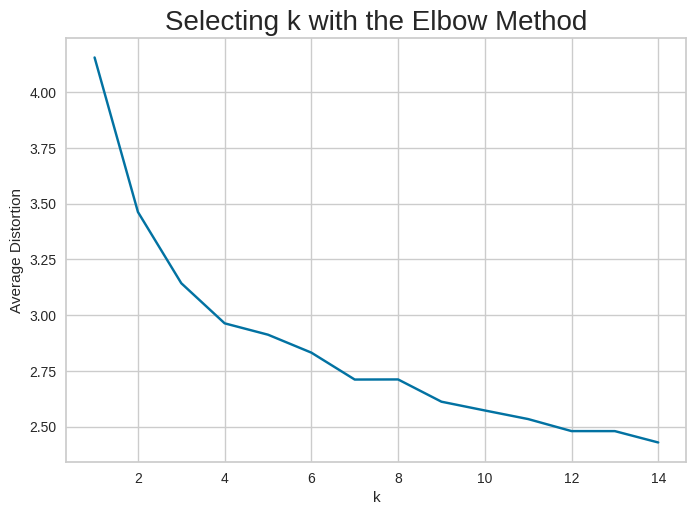

In [ ]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 6 or 7.**

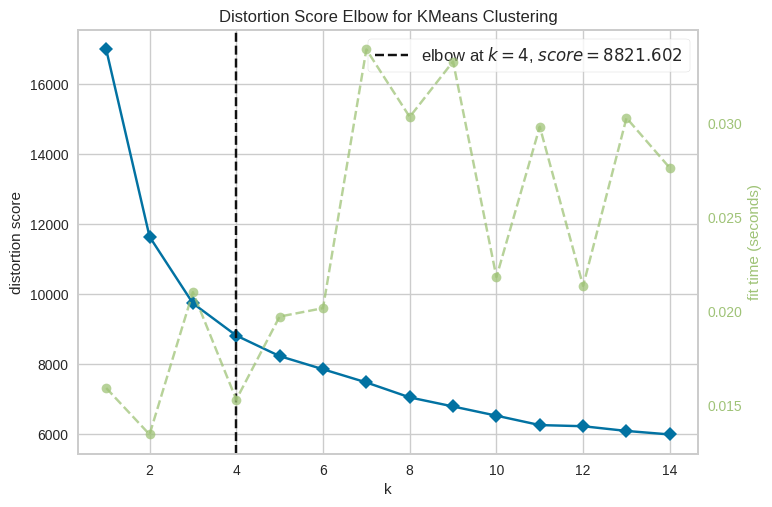

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

**The appropriate value of k from the elbow curve seems to be 7.**

### Check the silhouette scores

For n_clusters = 2, silhouette score is 0.29915345815602684
For n_clusters = 3, silhouette score is 0.21945843848937904
For n_clusters = 4, silhouette score is 0.21817010504843332
For n_clusters = 5, silhouette score is 0.1982798190747443
For n_clusters = 6, silhouette score is 0.19780488065872592
For n_clusters = 7, silhouette score is 0.1702022318743018
For n_clusters = 8, silhouette score is 0.18517175624663315
For n_clusters = 9, silhouette score is 0.16983964909487653
For n_clusters = 10, silhouette score is 0.146920420759104
For n_clusters = 11, silhouette score is 0.15212973866018656
For n_clusters = 12, silhouette score is 0.15260492765319758
For n_clusters = 13, silhouette score is 0.14393929780919665
For n_clusters = 14, silhouette score is 0.14828942480722979


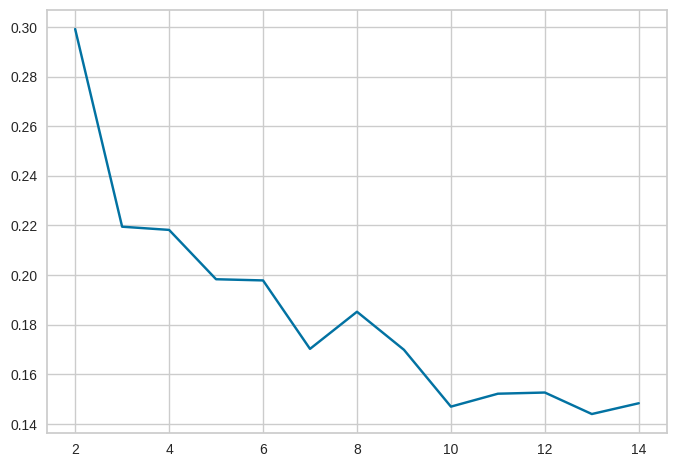

In [ ]:
sil_score = []
cluster_list = list(range(2, 15))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 6 is a good value of k.**

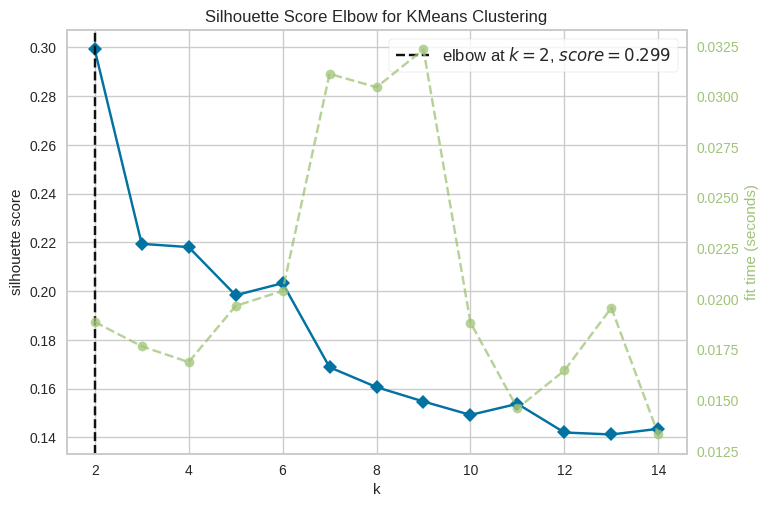

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

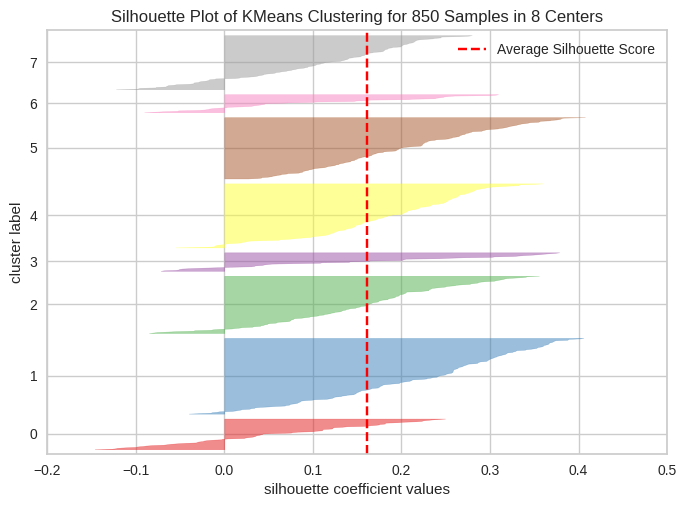

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 850 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

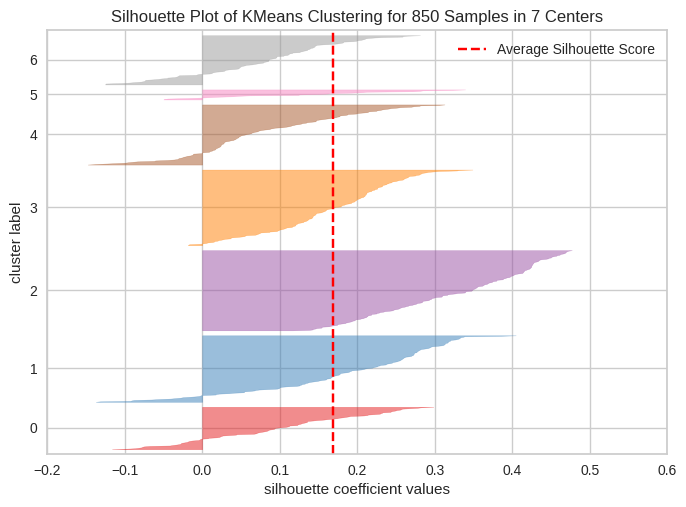

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 850 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

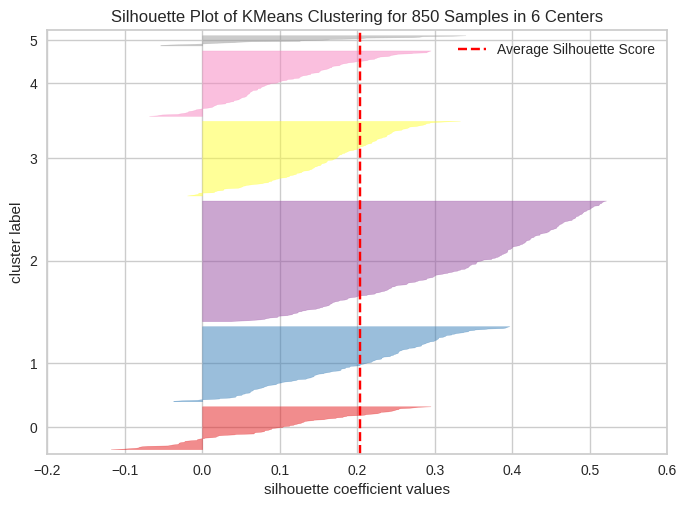

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 850 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

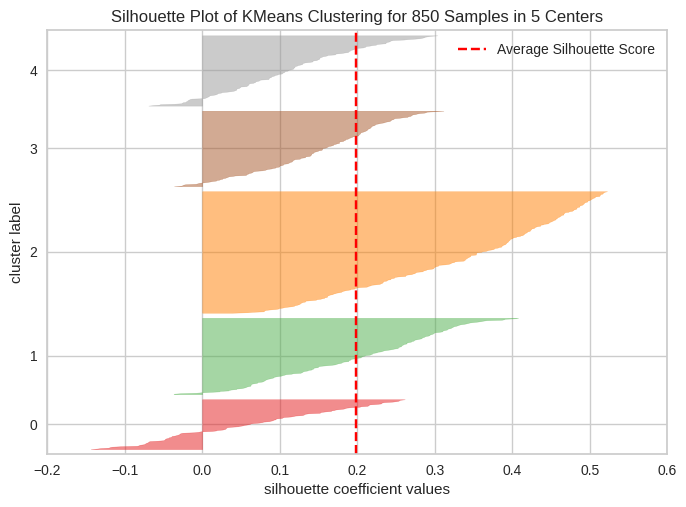

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 850 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

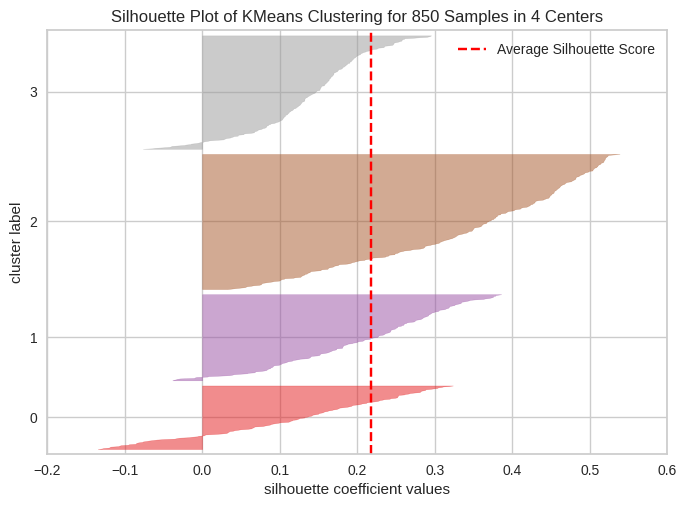

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 850 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

### Selecting final model

**Let's take 7 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 7 in the elbow curve.**

In [ ]:
%%time
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(subset_scaled_df)

CPU times: user 16 ms, sys: 2.02 ms, total: 18.1 ms
Wall time: 16.1 ms


KMeans(n_clusters=7, random_state=0)

In [ ]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [ ]:
# creating a copy of the original data
df1 = df.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_

In [ ]:
df1

playerId               firstName  \
0     8475233    {'default': 'David'}   
1     8475848  {'default': 'Brendan'}   
2     8476469     {'default': 'Joel'}   
3     8476875     {'default': 'Mike'}   
4     8476981     {'default': 'Josh'}   
..        ...                     ...   
845   8481607   {'default': 'Albert'}   
846   8481725    {'default': 'Elmer'}   
847   8482078    {'default': 'Lucas'}   
848   8482762    {'default': 'Simon'}   
849   8483464    {'default': 'Marco'}   

                                        lastName positionCode  gamesPlayed  \
0                          {'default': 'Savard'}            D           49   
1                       {'default': 'Gallagher'}            R           55   
2                           {'default': 'Armia'}            R           55   
3                        {'default': 'Matheson'}            D           53   
4                        {'default': 'Anderson'}            R           55   
..                                           ...          ...          ...   
845                     {'default': 'Johansson'}            D           34   
846  {'default': 'Soderblom', 'sv': 'Söderblom'}            L            9   
847                       {'default': 'Raymond'}            L           55   
848                     {'default': 'Edvinsson'}            D           51   
849                        {'default': 'Kasper'}            C           50   

     goals  assists  points  plusMinus  penaltyMinutes  powerPlayGoals  \
0        1        9      10         -7              26               0   
1       12        9      21        -13              25               4   
2       10       14      24          1              16               0   
3        4       20      24         -9              41               1   
4        8       10      18        -10              56               0   
..     ...      ...     ...        ...             ...             ...   
845      1        4       5         -3               8               0   
846      2        3       5          1               0               0   
847     21       38      59         -2              16               5   
848      5       16      21         11              34               0   
849      9       11      20         -7              20               2   

     shorthandedGoals  gameWinningGoals  overtimeGoals  shots  shootingPctg  \
0                   0                 0              0     34      0.029412   
1                   0                 1              0    101      0.118812   
2                   3                 1              0     82      0.121951   
3                   0                 0              0     99      0.040404   
4                   1                 0              0     73      0.109589   
..                ...               ...            ...    ...           ...   
845                 0                 1              0     26      0.038462   
846                 0                 1              0     13      0.153846   
847                 1                 3              1    129      0.162791   
848                 0                 2              1     51      0.098039   
849                 0                 1              0     82      0.109756   

     avgTimeOnIcePerGame  avgShiftsPerGame  faceoffWinPctg  goalsPerTime  \
0              1069.7551           20.8980        0.000000      0.000935   
1               822.2545           17.5455        0.000000      0.014594   
2               882.7273           17.8727        0.181818      0.011329   
3              1479.2075           25.0755        0.000000      0.002704   
4               848.3273           18.7091        0.617647      0.009430   
..                   ...               ...             ...           ...   
845             948.2647           20.9412        0.000000      0.001055   
846             765.3333           17.2222        0.400000      0.002613   
847            1136.8182           22.7455        0.0

## Cluster Profiling

In [ ]:
#cluster_profile = df1.groupby("K_means_segments").mean()
cluster_profile = df1.select_dtypes(include=np.number).groupby("K_means_segments").mean()

In [ ]:
cluster_profile["count_in_each_segment"] = (
    #df1.groupby("K_means_segments")["Security"].count().values
    df1.groupby("K_means_segments")["playerId"].count().values
)

In [ ]:
# let's display cluster profiles
display(cluster_profile.style.highlight_max(color="lightgreen", axis=0))
display(cluster_profile.style.highlight_min(color="red", axis=0))

####################Need to remove playerId as it is a number and causing problems

In [ ]:
#display name of lone stock in cluster 1
#df1[df1["KM_segments"] == 1]["Security"].unique()
df1[df1["KM_segments"] == 1]["playerId"].unique()

array([8475848, 8476469, 8477989, 8478133, 8479339, 8481523, 8481618,
       8482476, 8483515, 8479359, 8480802, 8481522, 8481528, 8482097,
       8483468, 8484145, 8475231, 8476419, 8478115, 8481237, 8481601,
       8484958, 8477505, 8479316, 8479336, 8481042, 8481477, 8484227,
       8474037, 8476374, 8479941, 8479944, 8482451, 8482705, 8471215,
       8475763, 8478046, 8478463, 8478569, 8479996, 8481481, 8481577,
       8477931, 8478542, 8480003, 8480185, 8482713, 8473533, 8475791,
       8476921, 8477478, 8478458, 8480762, 8480829, 8482809, 8476438,
       8476448, 8476871, 8478109, 8478434, 8478462, 8479353, 8482125,
       8475794, 8476278, 8478975, 8479351, 8480840, 8482145, 8482702,
       8476392, 8476480, 8478891, 8480113, 8480289, 8480845, 8474715,
       8476822, 8482070, 8483447, 8475760, 8477021, 8478474, 8478831,
       8479619, 8481711, 8474679, 8476873, 8476925, 8478438, 8482146,
       8476461, 8476872, 8480015, 8480068, 8480220, 8481553, 8482159,
       8483808, 8475

In [ ]:
#display name of lone stock in cluster 4
#df1[df1["KM_segments"] == 4]["Security"].unique()
df1[df1["KM_segments"] == 4]["playerId"].unique()

array([8475233, 8482733, 8477365, 8478413, 8480035, 8480196, 8480807,
       8481564, 8476422, 8477407, 8477950, 8479395, 8480306, 8480871,
       8481059, 8483448, 8471709, 8480043, 8480172, 8481567, 8482144,
       8482166, 8471677, 8475790, 8478099, 8481161, 8482475, 8483485,
       8477435, 8478854, 8479344, 8479576, 8481030, 8483503, 8481600,
       8484304, 8479980, 8480727, 8481527, 8474090, 8476856, 8478476,
       8480878, 8480950, 8483425, 8476525, 8477938, 8479639, 8481572,
       8481719, 8482201, 8482655, 8474145, 8478507, 8479976, 8480084,
       8480434, 8481609, 8483472, 8475857, 8478468, 8481056, 8481743,
       8482111, 8482482, 8483565, 8473446, 8481178, 8482126, 8482142,
       8482169, 8483495, 8474102, 8474612, 8478146, 8480879, 8482095,
       8482245, 8484321, 8475177, 8479387, 8481206, 8484258, 8479372,
       8481563, 8483482, 8483490, 8474563, 8479421, 8475762, 8476858,
       8478454, 8478465, 8483476, 8483768, 8475750, 8480990, 8475825,
       8476988, 8479

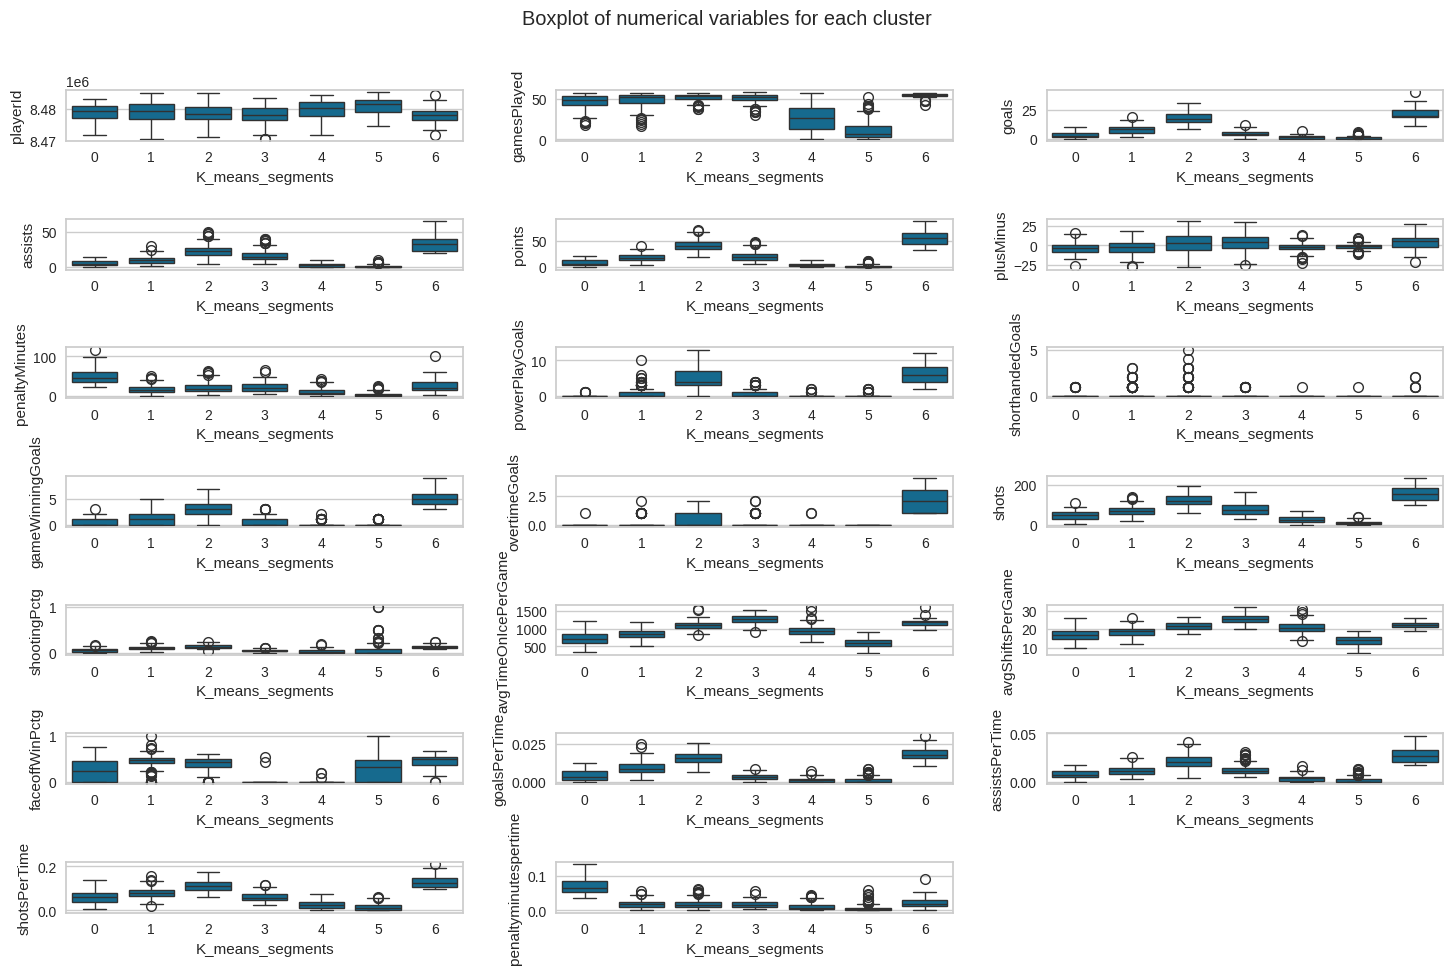

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(numeric_columns):
    plt.subplot(7, 3, i + 1)
    sns.boxplot(data=df, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

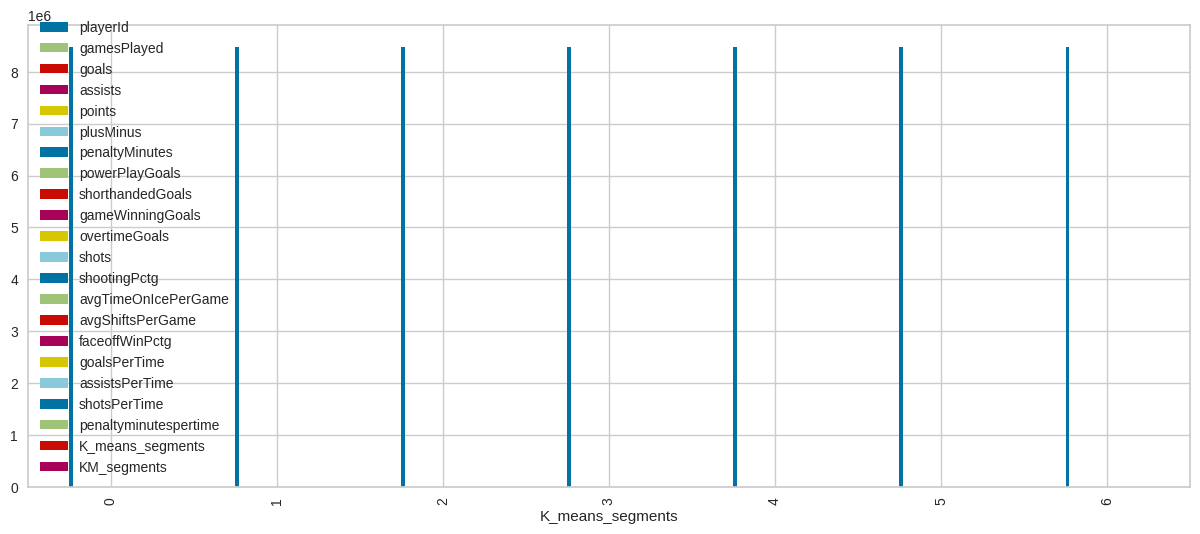

In [ ]:
# Selecting only numeric features for calculating the mean
numeric_features = df1.select_dtypes(include=np.number).columns
cluster_means = df1.groupby("K_means_segments")[numeric_features].mean()

# Plotting the bar chart
cluster_means.plot.bar(figsize=(15, 6))
plt.show()
#df1.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

In [ ]:
## Print the companies in each cluster
for cl in df1["KM_segments"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    #print(df1[df1["KM_segments"] == cl]["Security"].unique())
    print(df1[df1["KM_segments"] == cl]["playerId"].unique())
    print()

In cluster 4, the following players are present:
[8475233 8482733 8477365 8478413 8480035 8480196 8480807 8481564 8476422
 8477407 8477950 8479395 8480306 8480871 8481059 8483448 8471709 8480043
 8480172 8481567 8482144 8482166 8471677 8475790 8478099 8481161 8482475
 8483485 8477435 8478854 8479344 8479576 8481030 8483503 8481600 8484304
 8479980 8480727 8481527 8474090 8476856 8478476 8480878 8480950 8483425
 8476525 8477938 8479639 8481572 8481719 8482201 8482655 8474145 8478507
 8479976 8480084 8480434 8481609 8483472 8475857 8478468 8481056 8481743
 8482111 8482482 8483565 8473446 8481178 8482126 8482142 8482169 8483495
 8474102 8474612 8478146 8480879 8482095 8482245 8484321 8475177 8479387
 8481206 8484258 8479372 8481563 8483482 8483490 8474563 8479421 8475762
 8476858 8478454 8478465 8483476 8483768 8475750 8480990 8475825 8476988
 8479026 8479982 8481122 8477244 8478840 8480001 8481708 8482067 8475906
 8479442 8480834 8475197 8477810 8478211 8479402 8482470 8482624 8476854
 8

In [ ]:
#compare cluster Vs position
pd.crosstab(df1.KM_segments, df1['positionCode']).style.highlight_max(color="lightgreen", axis=0)

In [ ]:
df1.groupby(["KM_segments", "positionCode"])['playerId'].count()

KM_segments  positionCode
0            C                17
             D                12
             L                11
             R                 9
1            C               102
             L                55
             R                43
2            C                58
             D                 4
             L                33
             R                28
3            C                 2
             D               126
4            C                 3
             D               125
             L                 5
             R                 4
5            C                83
             D                26
             L                41
             R                38
6            C                12
             D                 1
             L                 4
             R                 8
Name: playerId, dtype: int64

##Observations

Group 0: Players who take the most shifts and play a high number of games. Primarily defensemen.

Group 1: Players who do not play many games or score much but excel in face-offs. Primarily forwards.

Group 2: Superstar players leading in all offensive categories. Mostly offensive players with a few defensemen included.

Group 3: Depth players who play a lot of games and contribute modestly.

Group 4: The largest group, consisting of players who play the least games and have the lowest offensive output. Nearly an even split between defense and forwards.

Group 5: The smallest group, consisting entirely of forwards who accumulate the most penalty minutes while still playing a significant number of games.

## Hierarchical Clustering

### Computing Cophenetic Correlation

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "cityblock"] #mahalanobis

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

#Before calculating linkage, replace infinite values with NaN and remove rows with NaN
subset_scaled_df = subset_scaled_df.replace([np.inf, -np.inf], np.nan).dropna()

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7484451428201625.
Cophenetic correlation for Euclidean distance and complete linkage is 0.6503836456630128.
Cophenetic correlation for Euclidean distance and average linkage is 0.7735679250818335.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.6473310449411115.
Cophenetic correlation for Chebyshev distance and single linkage is 0.5793666651984063.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.6378838159291507.
Cophenetic correlation for Chebyshev distance and average linkage is 0.6795329678636706.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.5827534287915089.
Cophenetic correlation for Cityblock distance and single linkage is 0.7389897266378805.
Cophenetic correlation for Cityblock distance and complete linkage is 0.5916268802507697.
Cophenetic correlation for Cityblock distance and average linkage is 0.6957999574347316.
Cophenetic correlat

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.7735679250818335, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7484451428201625.
Cophenetic correlation for complete linkage is 0.6503836456630128.
Cophenetic correlation for average linkage is 0.7735679250818335.
Cophenetic correlation for centroid linkage is 0.7604613927828232.
Cophenetic correlation for ward linkage is 0.4618017476659188.
Cophenetic correlation for weighted linkage is 0.6473310449411115.


In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.7735679250818335, which is obtained with average linkage.


##Observations
- We see that the cophenetic correlation is maximum with euclidean distance and average linkage.


### Checking Dendrograms

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

    #######################
    #Test to save dendograms as png
    # Save as PNG
    #plt.savefig(f"Dendrogram ({method.capitalize()} Linkage).png", dpi=300, bbox_inches='tight')
  #plt.show()
plt.savefig("Dendograms.png", dpi=300, bbox_inches='tight')

**Observations**

- Dendrogram for Ward linkage shows distinct and separate clusters.

In [ ]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

Linkage  Cophenetic Coefficient
0    single                0.748445
1  complete                0.650384
2   average                0.773568
3  centroid                0.760461
4      ward                0.461802
5  weighted                0.647331

**Let's see the dendrogram for Chebyshev distance and Euclidian distances with average and weighted linkage methods (as they gave high cophenetic correlation values).**

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

##Observations
- Out of all the dendrograms we saw, it is clear that the dendrogram with Ward linkage gave us separate and distinct clusters.
- 6 would be the appropriate number of the clusters from the dendrogram with Ward linkage method.

### Creating Final Model

In [ ]:
%%time
#HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
HCmodel = AgglomerativeClustering(n_clusters=6, linkage="ward")
HCmodel.fit(subset_scaled_df)

CPU times: user 32.8 ms, sys: 1 µs, total: 32.8 ms
Wall time: 34 ms


AgglomerativeClustering(n_clusters=6)

In [ ]:
# creating a copy of the original data
df2 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df2["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling

In [ ]:
#cluster_profile1 = df2.groupby("HC_Clusters").mean()
#only numeric columns to be used
cluster_profile1 = df2.select_dtypes(include=np.number).groupby("HC_Clusters").mean()
cluster_profile1

playerId  gamesPlayed      goals    assists     points  \
HC_Clusters                                                               
0            8.478360e+06    52.774194  18.854839  26.330645  45.185484   
1            8.479059e+06    48.348416   8.217195  11.013575  19.230769   
2            8.481013e+06    10.163462   0.677885   1.067308   1.745192   
3            8.478512e+06    50.678322   4.048951  15.524476  19.573427   
4            8.479301e+06    45.000000   5.263158   6.719298  11.982456   
5            8.478677e+06    28.505155   1.237113   3.917526   5.154639   

             plusMinus  penaltyMinutes  powerPlayGoals  shorthandedGoals  \
HC_Clusters                                                                
0             2.596774       23.008065        5.451613          0.548387   
1            -1.710407       15.628959        1.049774          0.217195   
2            -1.187500        3.028846        0.052885          0.004808   
3             3.230769       22.384615        0.552448          0.083916   
4            -4.578947       47.105263        0.614035          0.122807   
5            -2.567010       12.567010        0.072165          0.000000   

             gameWinningGoals  overtimeGoals       shots  shootingPctg  \
HC_Clusters                                                              
0                    3.322581       0.669355  133.943548      0.144814   
1                    1.217195       0.104072   70.986425      0.115081   
2                    0.096154       0.000000    8.985577      0.063464   
3                    0.636364       0.167832   74.811189      0.053179   
4                    0.631579       0.035088   53.157895      0.079278   
5                    0.144330       0.010309   27.268041      0.040083   

             avgTimeOnIcePerGame  avgShiftsPerGame  faceoffWinPctg  \
HC_Clusters                                                          
0                    1128.272944         21.993789        0.393487   
1                     860.424450         18.712810        0.428763   
2                     646.280565         14.858820        0.241580   
3                    1247.917569         25.222490        0.002248   
4                     727.715218         16.489642        0.286490   
5                     949.596877         20.939679        0.002226   

             goalsPerTime  assistsPerTime  shotsPerTime  \
HC_Clusters                                               
0                0.016711        0.023044      0.118307   
1                0.009335        0.012295      0.081380   
2                0.001034        0.001581      0.013894   
3                0.003158        0.012117      0.059174   
4                0.006382        0.008431      0.067956   
5                0.001373        0.004305      0.029784   

             penaltyminutespertime  K_means_segments  
HC_Clusters                                           
0                         0.020558          2.766129  
1                         0.018479          1.244344  
2                         0.004933          4.841346  
3                         0.018262          3.027972  
4                         0.065139          0.614035  
5                         0.013787          3.865979

In [ ]:
cluster_profile1["count_in_each_segments"] = (
    df2.groupby("HC_Clusters")["playerId"].count().values
)

In [ ]:
# let's display cluster profiles
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

# Create table
#table = cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

# Save as HTML
#table.to_html("dataframe_output.html")




In [ ]:
# Transpose the DataFrame first
df_transposed = cluster_profile1.T

# Apply styling AFTER transposing
styled_df = df_transposed.style.highlight_max(color="lightgreen", axis=1)

# Display the styled DataFrame
styled_df

In [ ]:
# Use 'Styler.to_excel' to export the table to Excel:
styled_df.to_excel("HC_Cluster_Max.xlsx", engine="openpyxl")

In [ ]:
#display cluster profiles and highlight the min red
display(cluster_profile1.style.highlight_min(color="red", axis=0))

In [ ]:
# Transpose the DataFrame first
df_transposed = cluster_profile1.T

# Apply styling AFTER transposing
styled_df_min = df_transposed.style.highlight_min(color="red", axis=1)

# Display the styled DataFrame
styled_df_min

In [ ]:
# Use 'Styler.to_excel' to export the table to Excel:
styled_df_min.to_excel("HC_Cluster_Min.xlsx", engine="openpyxl")

##Observations
Group 0 (Defensemen): Essential for a strong blue line.

Group 1 (Faceoff Specialists): The weakest group overall but still present.

Group 2 (All-Stars): Key offensive contributors.

Group 3 (Depth Players): Important secondary contributors.

Group 4 (Lower-Ranked Players): These players had limited impact.

Group 5 (Tough Guys): Provided grit, which proved valuable in the playoffs.

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(numeric_columns):
    plt.subplot(6, 4, i + 1)
    sns.boxplot(data=df2, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

**Let's compare Cluster vs Goals**

In [ ]:
#compare cluster Vs Goals
pd.crosstab(df2.HC_Clusters, df2['goals']).style.highlight_max(color="lightgreen", axis=0)

In [ ]:
## Complete the code to print the companies in each cluster
for cl in df2["HC_Clusters"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    print(df2[df2["HC_Clusters"] == cl]["playerId"].unique())
    print()

In cluster 3, the following players are present:
[8475233 8476875 8478851 8482087 8483457 8480839 8481524 8482671 8476429
 8476917 8477506 8480865 8481014 8478013 8479983 8480043 8480172 8481567
 8482667 8476923 8478500 8479371 8471724 8474578 8476891 8475179 8477220
 8477932 8478055 8478859 8484304 8470613 8475200 8476906 8476958 8478970
 8480336 8474565 8475188 8477447 8478396 8479980 8480727 8476879 8476902
 8480036 8480950 8481581 8476331 8477504 8479378 8480049 8480145 8474151
 8475167 8478178 8478416 8480246 8482655 8474013 8476874 8479410 8480891
 8474600 8476869 8483565 8476372 8477499 8477948 8481546 8482142 8475455
 8477488 8478399 8480192 8482684 8475324 8478469 8482095 8482105 8476312
 8478038 8479398 8484258 8476457 8476467 8478407 8482858 8474590 8477845
 8478911 8480796 8480873 8475208 8475462 8476885 8481605 8482803 8476441
 8478882 8479998 8481606 8474574 8477369 8477969 8479425 8480800 8474716
 8476463 8478136 8482122 8475171 8475690 8476853 8476931 8479982 8478840
 8

In [ ]:

df2.groupby(["HC_Clusters", "positionCode"])['playerId'].count()


HC_Clusters  positionCode
0            C                61
             D                 5
             L                28
             R                30
1            C               114
             D                 1
             L                58
             R                48
2            C                77
             D                55
             L                40
             R                36
3            D               142
             L                 1
4            C                22
             D                 6
             L                18
             R                11
5            C                 3
             D                85
             L                 4
             R                 5
Name: playerId, dtype: int64

In [ ]:
#compare cluster Vs position
pd.crosstab(df2.HC_Clusters, df2['positionCode']).style.highlight_max(color="lightgreen", axis=0)

In [ ]:
# Use 'Styler.to_excel' to export the table to Excel:
#cluster_profile1.style.highlight_max(color="lightgreen", axis=0).to_excel("dataframe_output.xlsx", engine="openpyxl")
crosstab = pd.crosstab(df2.HC_Clusters, df2['positionCode']).style.highlight_max(color="lightgreen", axis=0)
crosstab.to_excel("crosstab.xlsx", engine="openpyxl")

CPU times: user 2.21 s, sys: 161 ms, total: 2.37 s
Wall time: 2.33 s


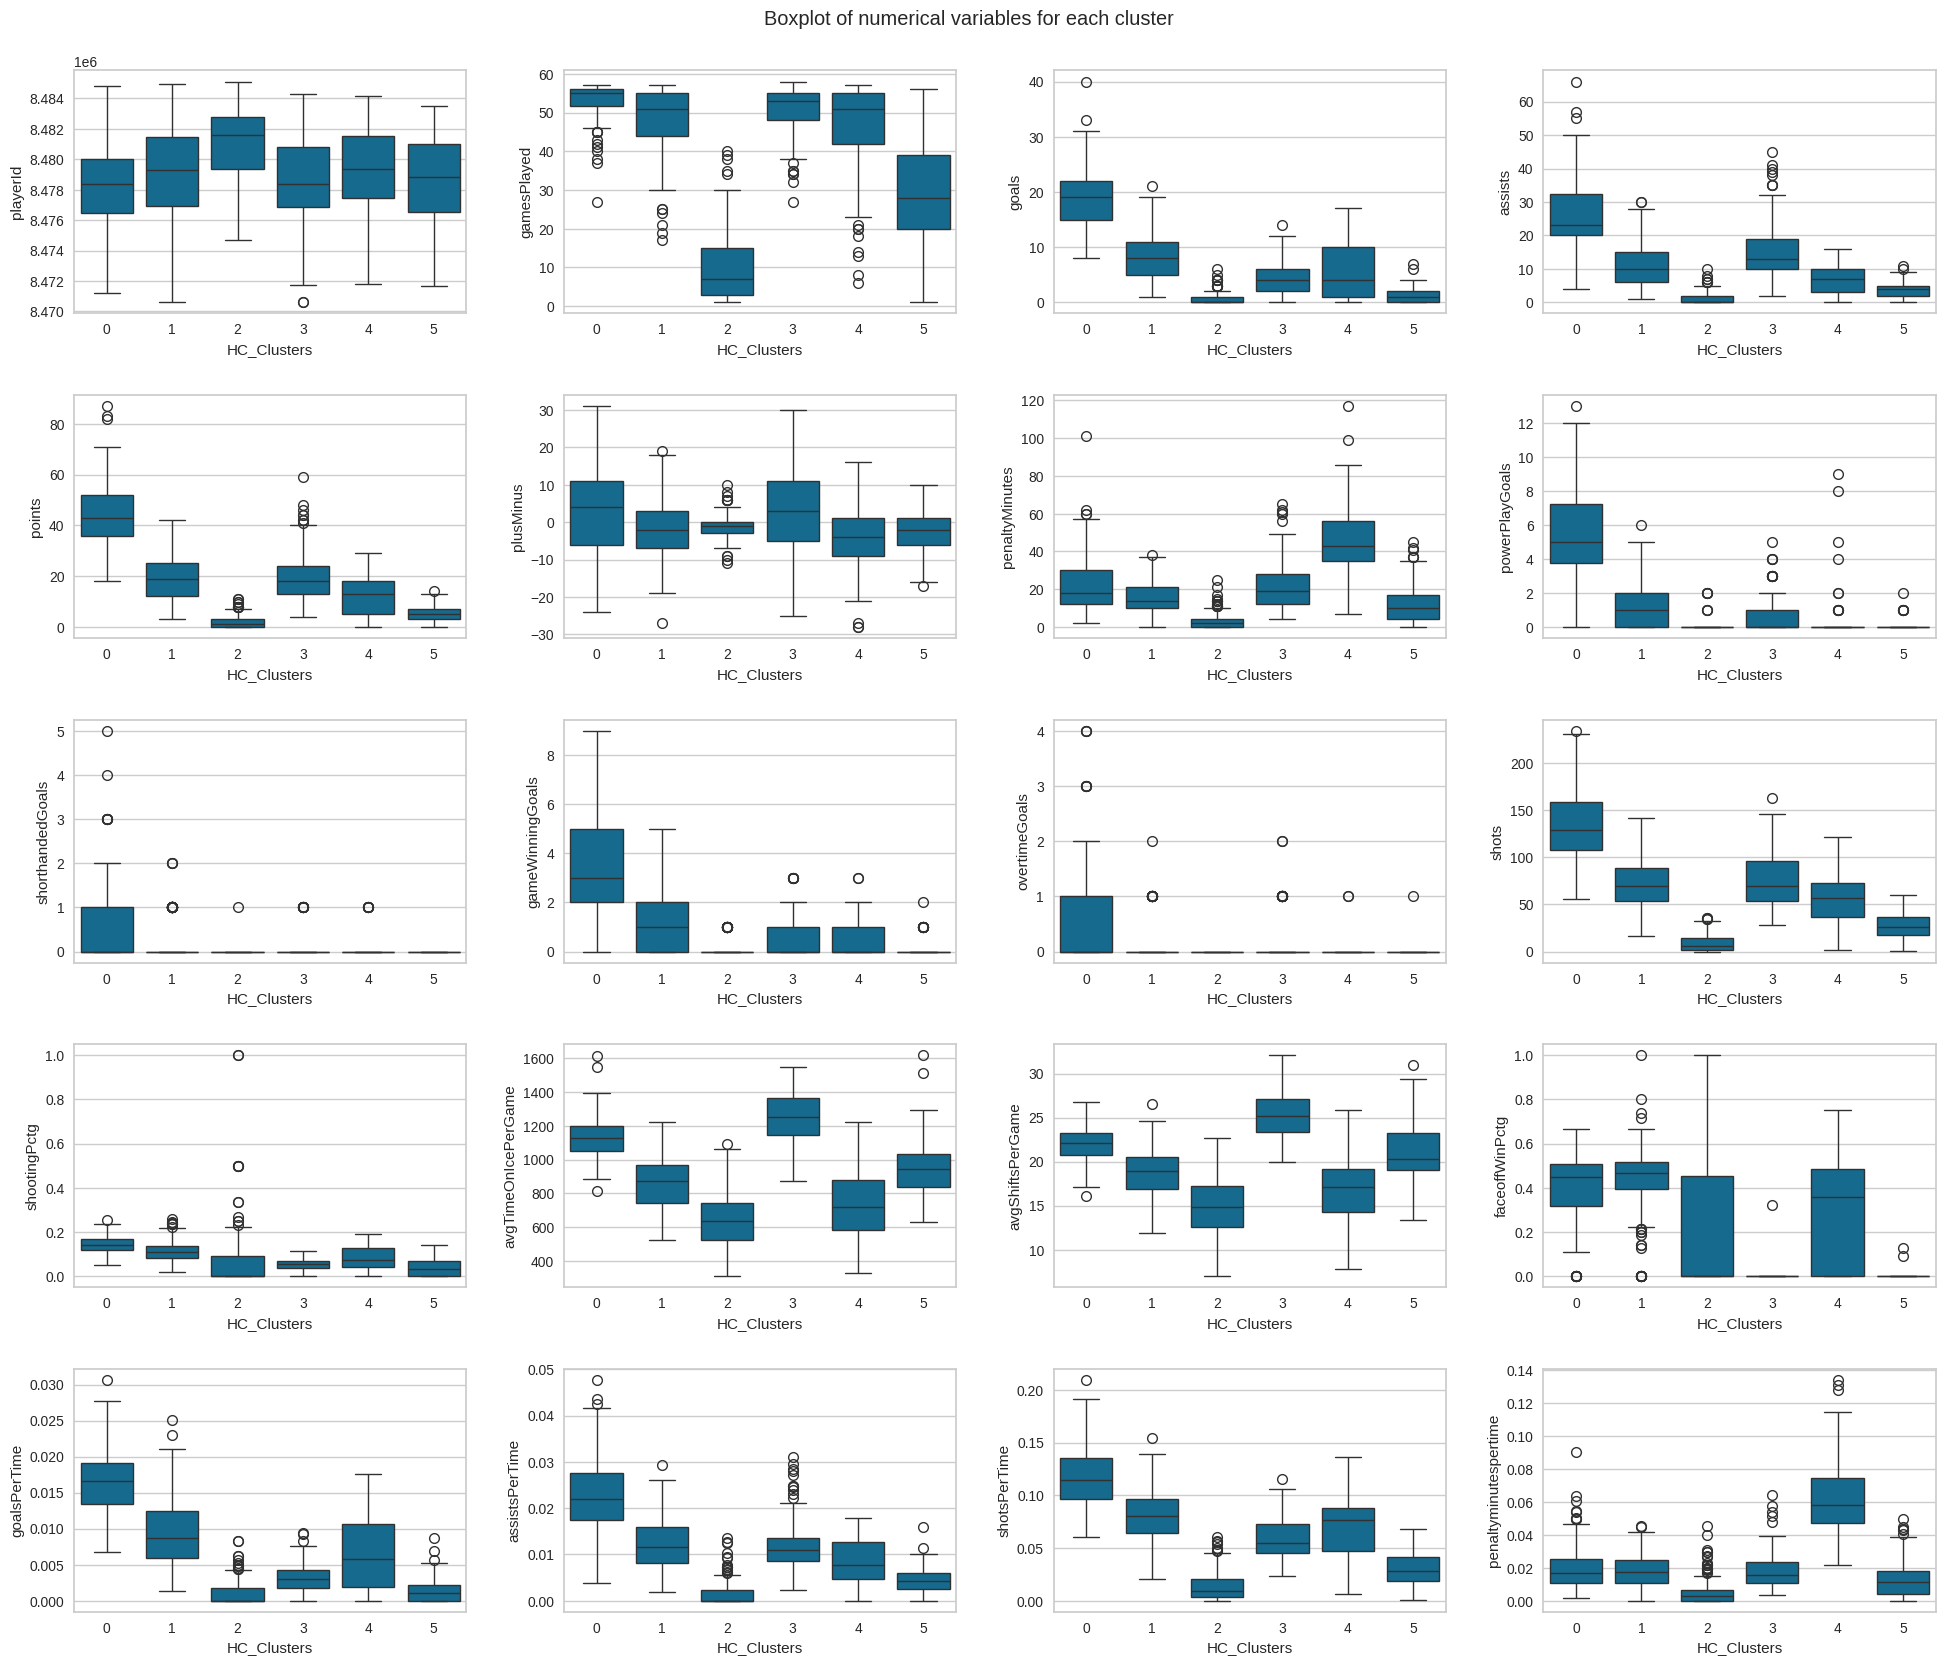

In [ ]:
%%time
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(numeric_columns):
    plt.subplot(6, 4, i + 1)
    sns.boxplot(data=df2, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)


## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [ ]:
# let's display K-means cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [ ]:
# let's display Heirerchical cluster profiles
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

In [ ]:
# Mapping old values to new values
#0=2 allstars
#1=1 faceoffs, highest group
#2=4 not many games-defense
#3=0 most time on ice/shifts per game and plus minus-defense
#4=5 high penalties
#5=3 bottom rung of players-defense

df3=df2 #create new dataframe that is the same as df2
df3['HC_Clusters'] = df3['HC_Clusters'].replace({0: 2, 1: 1, 2: 4, 3: 0, 4: 5 , 5: 3})

In [ ]:
#compare cluster Vs position
pd.crosstab(df3.HC_Clusters, df3['positionCode']).style.highlight_max(color="lightgreen", axis=0)

## Dimensionality Reduction using PCA for visualization

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [ ]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 2
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

In [ ]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.5897504498997473

- The first two principal components explain 36.9% of the variance in the data.

<Axes: xlabel='Component 1', ylabel='Component 2'>

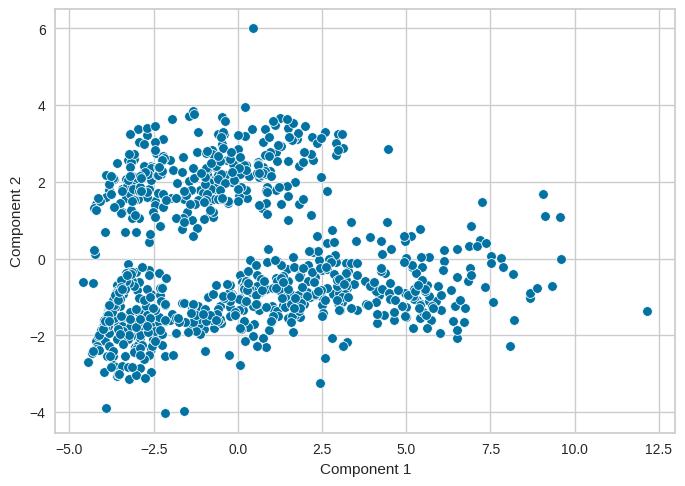

In [ ]:
sns.scatterplot(data=reduced_df_pca, x="Component 1", y="Component 2")

- We can kind of see 6 broad clusters if we draw a horizontal line around y=-3 and y=3 and a vertical line around x=-2
- There a few outlier points too.

Let's colour the scatterplot by cluster labels.

In [ ]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=df3["HC_Clusters"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

# Save as PNG
plt.savefig("ScatterPlot.png", dpi=300, bbox_inches='tight')

- Cluster 3 and 4 are the major clusters.
- The rest of the data points seem to be mostly outliers.

#plotting distribution of clusters

In [ ]:
#pl = sns.countplot(x=df2["HC_Clusters"])
#labeled_barplot(playerdata, "positionCode", perc=True)
labeled_barplot(df3, "HC_Clusters", perc=True)

# Get the current figure
fig = plt.gcf()  # GCF = Get Current Figure

# Save as PNG
fig.savefig("LeagueDistributionofClusters.png", dpi=300, bbox_inches="tight")

#pl.set_title("Distribution Of The Clusters")
# Save as PNG
#plt.savefig("LeagueDistributionofClusters.png", dpi=300, bbox_inches='tight')
#plt.show();

<Figure size 800x550 with 0 Axes>

In [ ]:
#list of nhl teams minus utah or arizona depending on year.

TeamList = ['MTL', 'BUF', 'NYI', 'SJS', 'CBJ', 'PIT', 'FLA', 'CAR', 'VGK', 'DAL', 'WPG', 'TBL', 'NSH', 'PHI', 'NJD', 'OTT', 'COL', 'SEA', 'WSH', 'ANA', 'LAK', 'VAN', 'MIN', 'TOR', 'NYR', 'EDM', 'CGY', 'BOS', 'STL', 'CHI', 'DET']
Topfourteams = ['WPG', 'EDM','WSH','DAL']
Otherteams = [x for x in TeamList if x not in Topfourteams]

print(Otherteams)

#count = len(Otherteams)
#print(count)  # Output: 4

['MTL', 'BUF', 'NYI', 'SJS', 'CBJ', 'PIT', 'FLA', 'CAR', 'VGK', 'TBL', 'NSH', 'PHI', 'NJD', 'OTT', 'COL', 'SEA', 'ANA', 'LAK', 'VAN', 'MIN', 'TOR', 'NYR', 'CGY', 'BOS', 'STL', 'CHI', 'DET']


https://api-web.nhle.com/v1/club-stats/WPG/20242025/2
Distribution Of The Clusters on the WPG


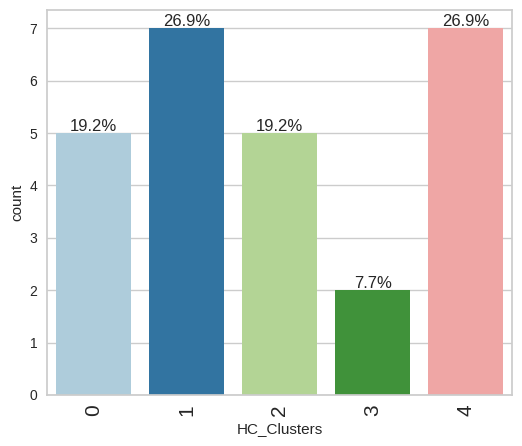

https://api-web.nhle.com/v1/club-stats/EDM/20242025/2
Distribution Of The Clusters on the EDM


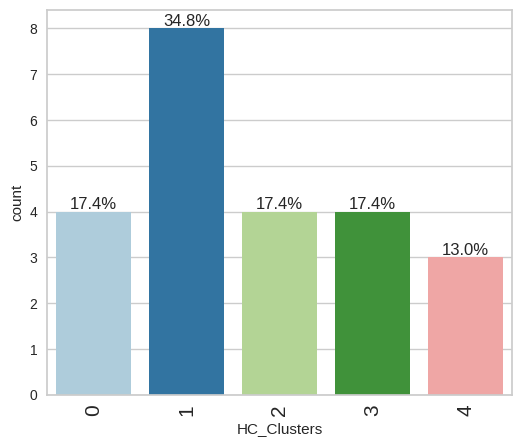

https://api-web.nhle.com/v1/club-stats/WSH/20242025/2
Distribution Of The Clusters on the WSH


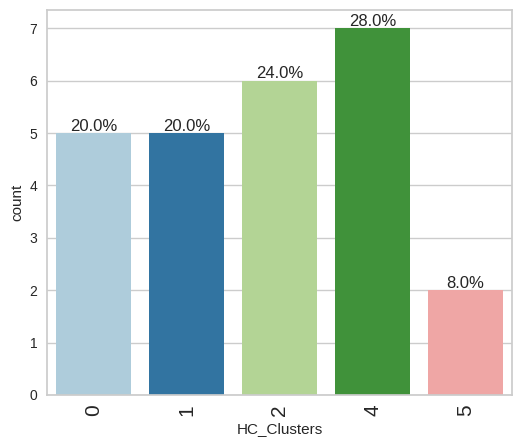

https://api-web.nhle.com/v1/club-stats/DAL/20242025/2
Distribution Of The Clusters on the DAL


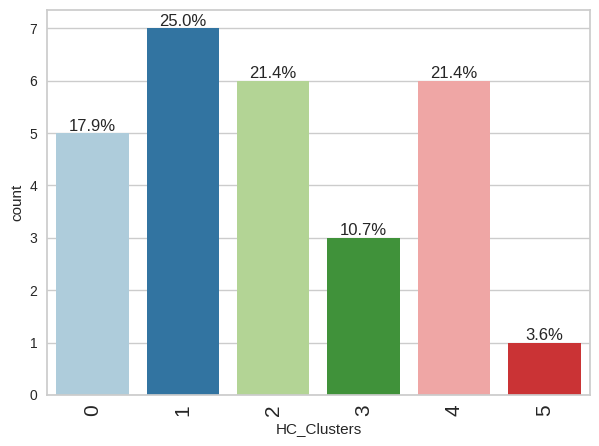

In [ ]:
#loop through top four teams and graph HC_clusters

# Initialize an empty DataFrame
#NHL_players_df = pd.DataFrame()

import requests
import json
import pandas as pd

for team in Topfourteams:

    url = "https://api-web.nhle.com/v1/club-stats/" + team + "/20242025/2"

    print(url)

    payload = {}
    headers = {
      'accept': '*/*',
      'accept-language': 'en-US,en;q=0.9',
      'if-none-match': 'W/"679e2c37--gzip"',
      'origin': 'https://www.nhl.com',
      'priority': 'u=1, i',
      'referer': 'https://www.nhl.com/',
      'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Microsoft Edge";v="132"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36 Edg/132.0.0.0'
    }

    r = requests.get(url, headers=headers)

    playerdata = r.json()

    df1 = team
    df1 = pd.DataFrame(playerdata['skaters'])

    #use df2 with player category and reference player id to determine their category for plotting
    #add cluster to hawks_df;df2 is the one with clusters
    #df2.head()

    # Filter df2 to only include rows where playerid exists from hawks_df.  This will give us the hawks team df
    #filtered_df1 = df2[df2['playerId'].isin(df1['playerId'])]
    filtered_df1 = df3[df3['playerId'].isin(df1['playerId'])]

    #show HC_clusters for each top 4 team.

    #pl = sns.countplot(x=filtered_df1["HC_Clusters"])
    #pl.set_title("Distribution Of The Clusters on the " + team)
    #plt.title("Distribution Of The Clusters on the " + team)
    print("Distribution Of The Clusters on the " + team)
    labeled_barplot(filtered_df1, "HC_Clusters", perc=True)
    #plt.show();


    #print(df1)
    #df = pd.DataFrame({'A': [i], 'B': [i * 2]})  # Create a small DataFrame
    #NHL_players_df = pd.concat([NHL_players_df, df1], ignore_index=True)  # Concatenate

#need to figure out how to concactanate dataframe for all teams.

#NHL_players_df


https://api-web.nhle.com/v1/club-stats/MTL/20242025/2
Distribution Of The Clusters on the MTL


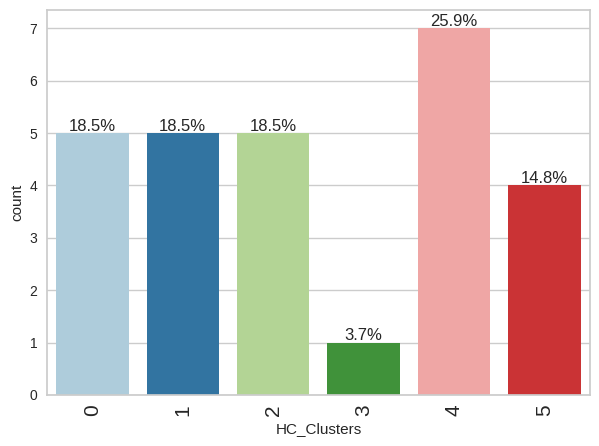

https://api-web.nhle.com/v1/club-stats/BUF/20242025/2
Distribution Of The Clusters on the BUF


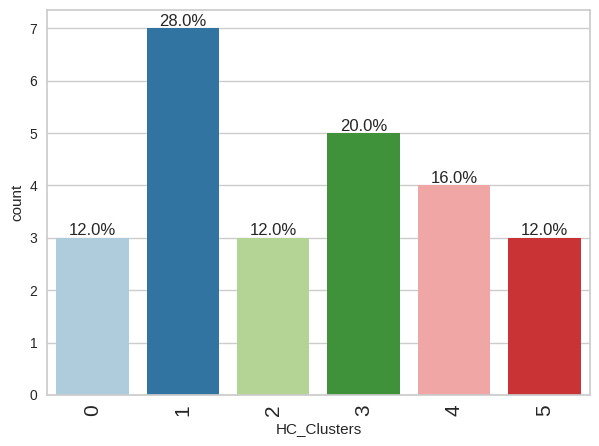

https://api-web.nhle.com/v1/club-stats/NYI/20242025/2
Distribution Of The Clusters on the NYI


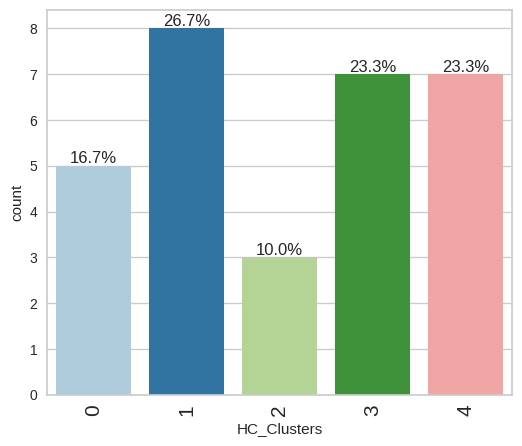

https://api-web.nhle.com/v1/club-stats/SJS/20242025/2
Distribution Of The Clusters on the SJS


https://api-web.nhle.com/v1/club-stats/CBJ/20242025/2
Distribution Of The Clusters on the CBJ


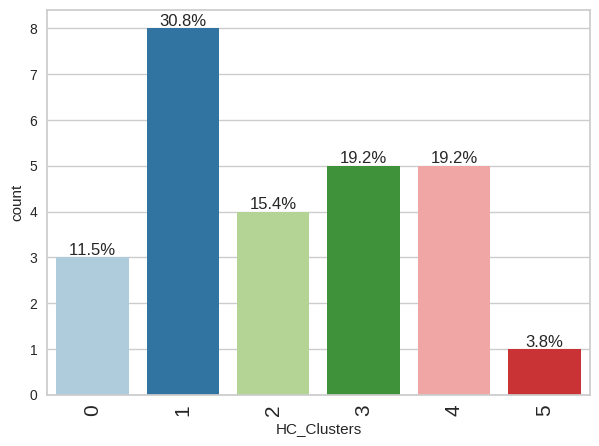

https://api-web.nhle.com/v1/club-stats/PIT/20242025/2
Distribution Of The Clusters on the PIT


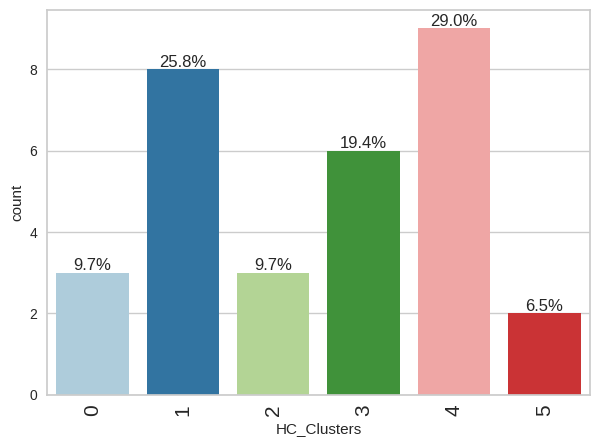

https://api-web.nhle.com/v1/club-stats/FLA/20242025/2
Distribution Of The Clusters on the FLA


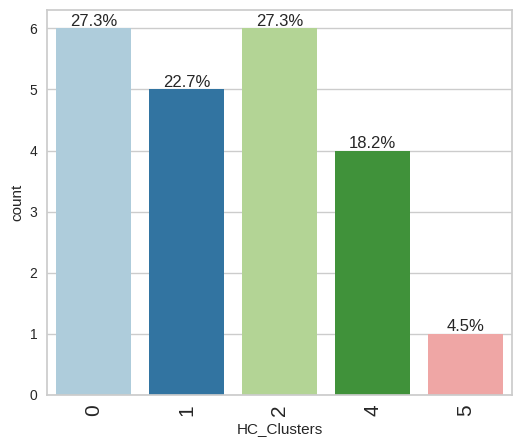

https://api-web.nhle.com/v1/club-stats/CAR/20242025/2
Distribution Of The Clusters on the CAR


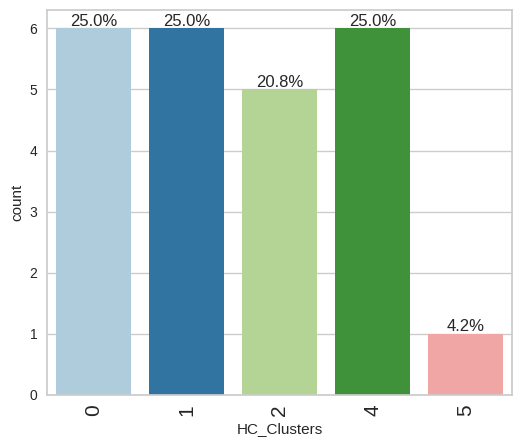

https://api-web.nhle.com/v1/club-stats/VGK/20242025/2
Distribution Of The Clusters on the VGK


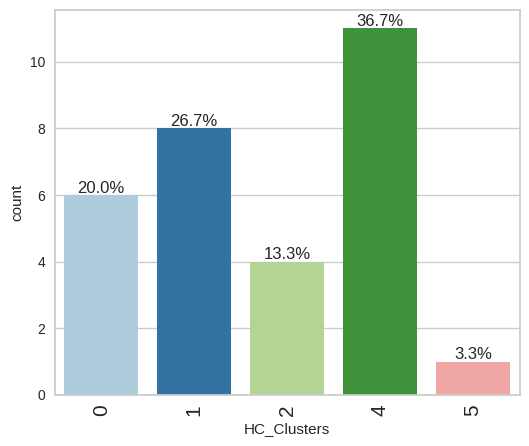

https://api-web.nhle.com/v1/club-stats/TBL/20242025/2
Distribution Of The Clusters on the TBL


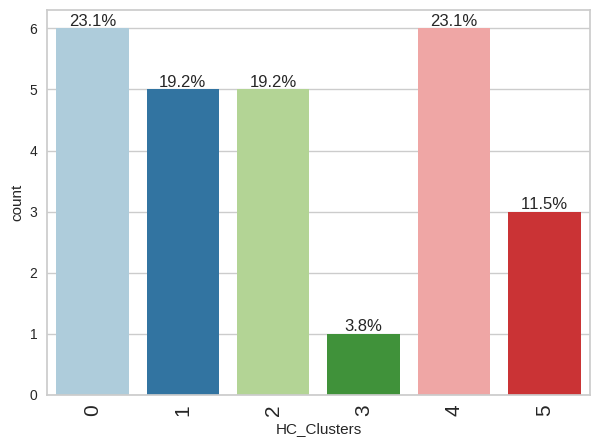

https://api-web.nhle.com/v1/club-stats/NSH/20242025/2
Distribution Of The Clusters on the NSH


https://api-web.nhle.com/v1/club-stats/PHI/20242025/2
Distribution Of The Clusters on the PHI


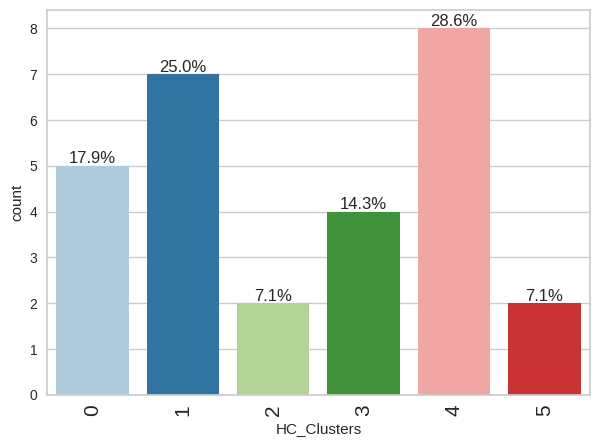

https://api-web.nhle.com/v1/club-stats/NJD/20242025/2
Distribution Of The Clusters on the NJD


https://api-web.nhle.com/v1/club-stats/OTT/20242025/2
Distribution Of The Clusters on the OTT


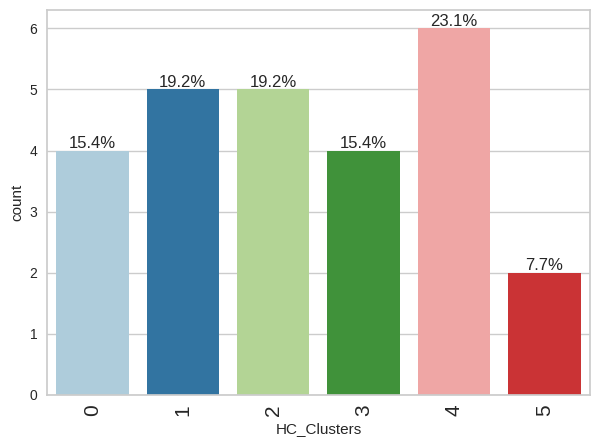

https://api-web.nhle.com/v1/club-stats/COL/20242025/2
Distribution Of The Clusters on the COL


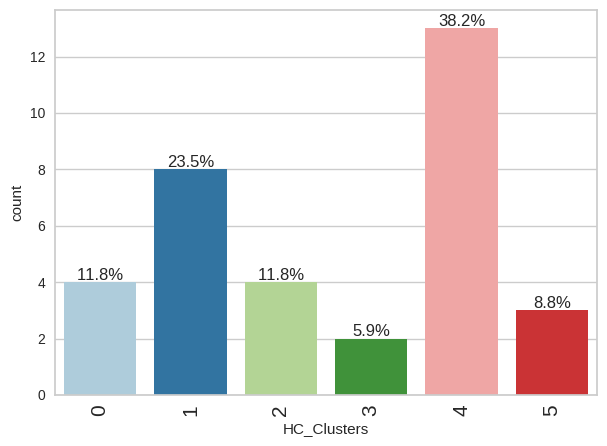

https://api-web.nhle.com/v1/club-stats/SEA/20242025/2
Distribution Of The Clusters on the SEA


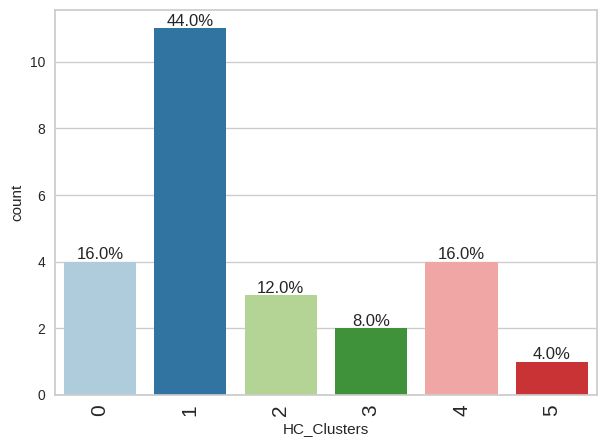

https://api-web.nhle.com/v1/club-stats/ANA/20242025/2
Distribution Of The Clusters on the ANA


https://api-web.nhle.com/v1/club-stats/LAK/20242025/2
Distribution Of The Clusters on the LAK


https://api-web.nhle.com/v1/club-stats/VAN/20242025/2
Distribution Of The Clusters on the VAN


https://api-web.nhle.com/v1/club-stats/MIN/20242025/2
Distribution Of The Clusters on the MIN


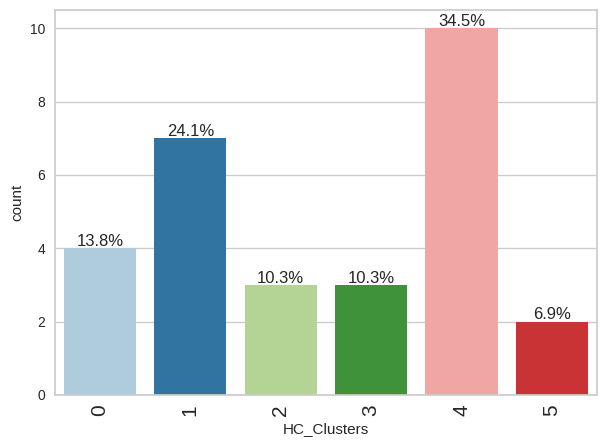

https://api-web.nhle.com/v1/club-stats/TOR/20242025/2
Distribution Of The Clusters on the TOR


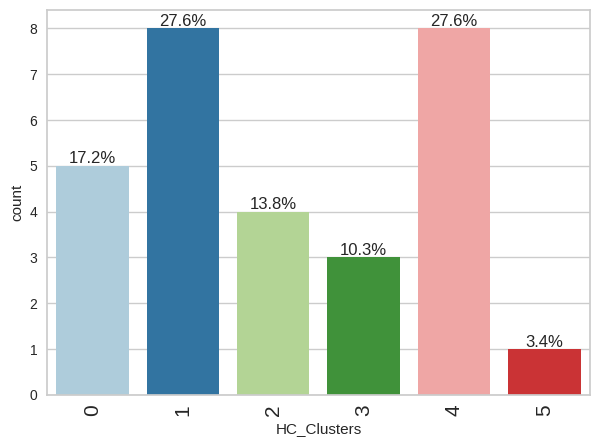

https://api-web.nhle.com/v1/club-stats/NYR/20242025/2
Distribution Of The Clusters on the NYR


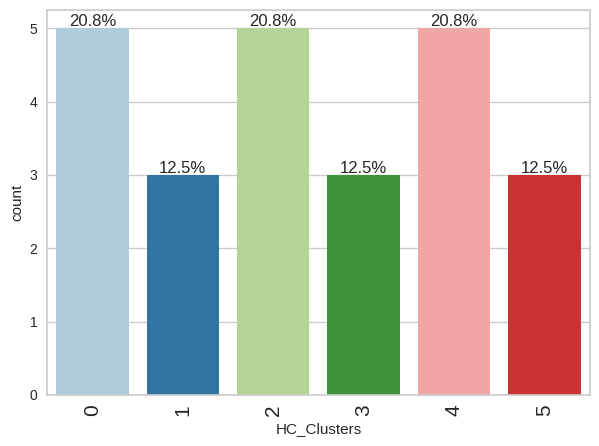

https://api-web.nhle.com/v1/club-stats/CGY/20242025/2
Distribution Of The Clusters on the CGY


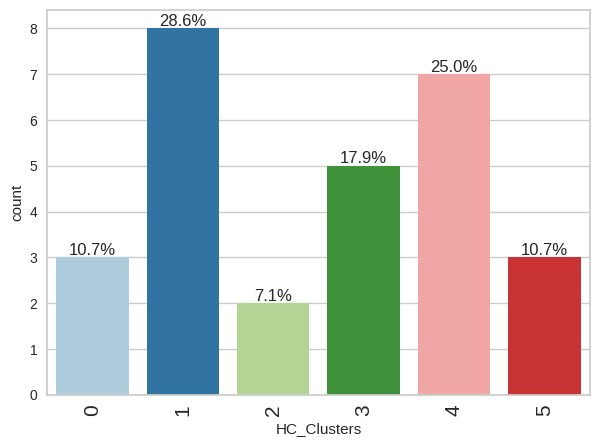

https://api-web.nhle.com/v1/club-stats/BOS/20242025/2
Distribution Of The Clusters on the BOS


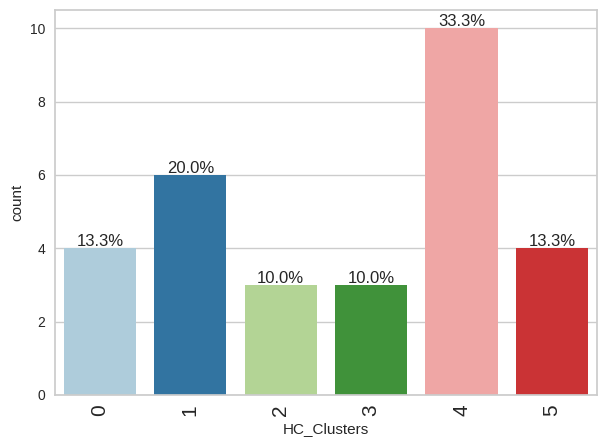

https://api-web.nhle.com/v1/club-stats/STL/20242025/2
Distribution Of The Clusters on the STL


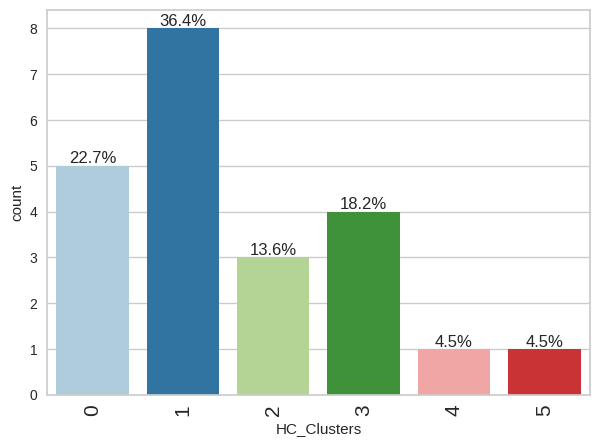

https://api-web.nhle.com/v1/club-stats/CHI/20242025/2
Distribution Of The Clusters on the CHI


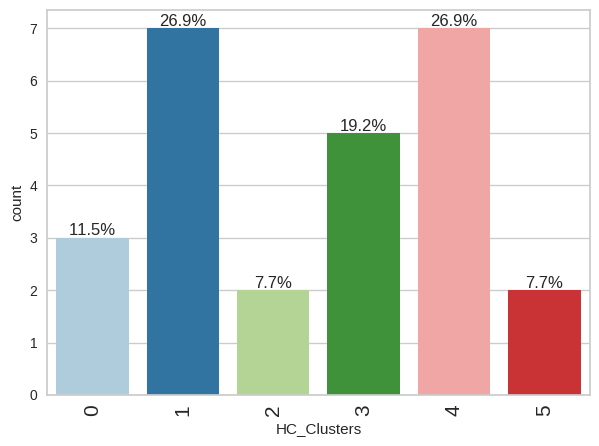

https://api-web.nhle.com/v1/club-stats/DET/20242025/2
Distribution Of The Clusters on the DET


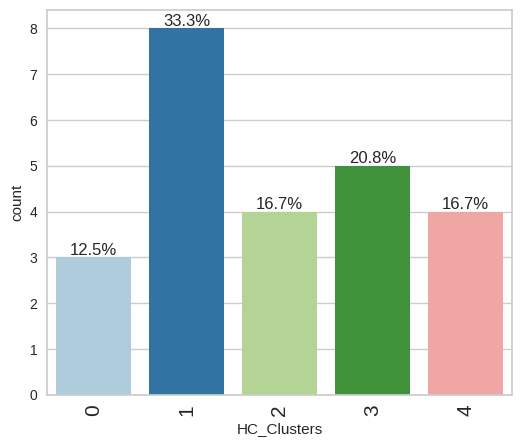

In [ ]:
#loop through the rest of the nhl teams and graph HC_clusters

for team in Otherteams:

    url = "https://api-web.nhle.com/v1/club-stats/" + team + "/20242025/2"

    print(url)

    payload = {}
    headers = {
      'accept': '*/*',
      'accept-language': 'en-US,en;q=0.9',
      'if-none-match': 'W/"679e2c37--gzip"',
      'origin': 'https://www.nhl.com',
      'priority': 'u=1, i',
      'referer': 'https://www.nhl.com/',
      'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Microsoft Edge";v="132"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36 Edg/132.0.0.0'
    }

    r = requests.get(url, headers=headers)

    playerdata = r.json()

    df1 = team
    df1 = pd.DataFrame(playerdata['skaters'])

    #use df2 with player category and reference player id to determine their category for plotting
    #add cluster to hawks_df;df2 is the one with clusters
    #df2.head()

    # Filter df2 to only include rows where playerid exists from hawks_df.  This will give us the hawks team df
    #filtered_df1 = df2[df2['playerId'].isin(df1['playerId'])]
    filtered_df1 = df3[df3['playerId'].isin(df1['playerId'])]

    #show HC_clusters for each top 4 team.

    #pl = sns.countplot(x=filtered_df1["HC_Clusters"])
    #pl.set_title("Distribution Of The Clusters on the " + team)
    #plt.show();

    print("Distribution Of The Clusters on the " + team)
    labeled_barplot(filtered_df1, "HC_Clusters", perc=True)




In [ ]:
#need to get a dataframe of blackhawks and then link their HC_cluster score to them.

import requests
import json
import pandas as pd

url = "https://api-web.nhle.com/v1/club-stats/CHI/20232024/2"

payload = {}
headers = {
  'accept': '*/*',
  'accept-language': 'en-US,en;q=0.9',
  'if-none-match': 'W/"679e2c37--gzip"',
  'origin': 'https://www.nhl.com',
  'priority': 'u=1, i',
  'referer': 'https://www.nhl.com/',
  'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Microsoft Edge";v="132"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'cross-site',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36 Edg/132.0.0.0'
}

r = requests.get(url, headers=headers)

playerdata = r.json()

playerdata.keys()

#playerdata['season']

playerdata['skaters'][0]


hawks_df = pd.DataFrame(playerdata['skaters'])
hawks_df


playerId                                           headshot  \
0    8470621  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
1    8473422  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
2    8474870  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
3    8475791  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
4    8475797  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
5    8476278  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
6    8476473  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
7    8476960  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
8    8477034  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
9    8477450  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
10   8477482  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
11   8477495  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
12   8477987  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
13   8478463  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
14   8478881  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
15   8479315  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
16   8479383  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
17   8479390  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
18   8479458  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
19   8479514  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
20   8480025  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
21   8480252  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
22   8480798  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
23   8481147  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
24   8481568  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
25   8481806  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
26   8482117  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
27   8482172  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
28   8482176  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
29   8482192  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
30   8482807  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
31   8483466  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
32   8483493  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
33   8483619  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   
34   8484144  https://assets.nhle.com/mugs/nhl/20232024/CHI/...   

                                            firstName  \
0                                {'default': 'Corey'}   
1                                 {'default': 'Nick'}   
2                                {'default': 'Tyler'}   
3                               {'default': 'Taylor'}   
4                               {'default': 'Jarred'}   
5                                {'default': 'Colin'}   
6                               {'default': 'Connor'}   
7                              {'default': 'Andreas'}   
8                               {'default': 'Jaycob'}   
9                                {'default': 'Jason'}   
10  {'default': 'Zachary', 'cs': 'Zach', 'de': 'Za...   
11                                {'default': 'Seth'}   
12                                {'default': 'Ryan'}   
13                             {'default': 'Anthony'}   
14                               {'default': 'Brett'}   
15                                {'default': 'Joey'}   
16                               {'default': 'Boris'}   
17                              {'default': 'Taylor'}   
18                              {'default': 'Nikita'}   
19                                 {'default': 'Rem'}   
20                           {'default': 'MacKenzie'}   
21                                {'default': 'Cole'}   
22                             {'default': 'Philipp'}   
23                               {'default': 'Reese'}   
24                                {'default': 'Alex'}   
25                               {'default': 'Louis'}   
26                               {'default': 'Lukas'

In [ ]:
#need to get a dataframe of Panthers and then link their HC_cluster score to them.

import requests
import json
import pandas as pd

url = "https://api-web.nhle.com/v1/club-stats/FLA/20232024/2"

payload = {}
headers = {
  'accept': '*/*',
  'accept-language': 'en-US,en;q=0.9',
  'if-none-match': 'W/"679e2c37--gzip"',
  'origin': 'https://www.nhl.com',
  'priority': 'u=1, i',
  'referer': 'https://www.nhl.com/',
  'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Microsoft Edge";v="132"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'cross-site',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36 Edg/132.0.0.0'
}

r = requests.get(url, headers=headers)

playerdata = r.json()

playerdata.keys()

#playerdata['season']

playerdata['skaters'][0]


panthers_df = pd.DataFrame(playerdata['skaters'])
panthers_df


playerId                                           headshot  \
0    8473449  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
1    8475171  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
2    8475179  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
3    8475765  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
4    8476393  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
5    8476422  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
6    8477409  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
7    8477493  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
8    8477932  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
9    8477933  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
10   8477935  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
11   8477986  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
12   8478055  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
13   8478542  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
14   8478831  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
15   8478859  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
16   8478904  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
17   8479066  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
18   8479314  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
19   8479367  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
20   8479372  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
21   8479981  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
22   8480185  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
23   8481600  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
24   8482088  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
25   8482113  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
26   8482713  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   
27   8484304  https://assets.nhle.com/mugs/nhl/20232024/FLA/...   

                                            firstName  \
0                                 {'default': 'Kyle'}   
1                               {'default': 'Oliver'}   
2   {'default': 'Dmitry', 'cs': 'Dmitrij', 'fi': '...   
3                             {'default': 'Vladimir'}   
4                                 {'default': 'Nick'}   
5                                 {'default': 'Mike'}   
6                               {'default': 'Carter'}   
7                           {'default': 'Aleksander'}   
8                                {'default': 'Aaron'}   
9                                  {'default': 'Sam'}   
10                                 {'default': 'Sam'}   
11                             {'default': 'Brandon'}   
12                              {'default': 'Gustav'}   
13                                {'default': 'Evan'}   
14                               {'default': 'Kevin'}   
15                                {'default': 'Niko'}   
16                              {'default': 'Steven'}   
17                                {'default': 'Ryan'}   
18                             {'default': 'Matthew'}   
19                             {'default': 'William'}   
20  {'default': 'Joshua', 'cs': 'Josh', 'de': 'Jos...   
21                               {'default': 'Jonah'}   
22                                {'default': 'Eetu'}   
23                              {'default': 'Tobias'}   
24                              {'default': 'Justin'}   
25                               {'default': 'Anton'}   
26                              {'default': 'Mackie'}   
27                                {'default': 'Uvis'}   

                                             lastName positionCode  \
0                               {'default': 'Okposo'}            R   
1                        {'default': 'Ekman-Larsson'}            D   
2                              {'default': 'Kulikov'}            D   
3                            {'default': 'Tarasenko'}            R   
4                              {'default': 'Cousins'}   

In [ ]:
#add cluster to hawks_df;df2 is the one with clusters
df2.head()

# Filter df2 to only include rows where playerid exists from hawks_df.  This will give us the hawks team df
filtered_hawks_df = df2[df2['playerId'].isin(hawks_df['playerId'])]

#print(filtered_df)

In [ ]:
#add cluster to hawks_df;df2 is the one with clusters
df2.head()

# Filter df2 to only include rows where playerid exists from hawks_df.  This will give us the hawks team df
filtered_panthers_df = df2[df2['playerId'].isin(panthers_df['playerId'])]

print(filtered_panthers_df)

     playerId                                          firstName  \
58    8476422                                {'default': 'Mike'}   
166   8475179  {'default': 'Dmitry', 'cs': 'Dmitrij', 'fi': '...   
168   8477409                              {'default': 'Carter'}   
169   8477493                          {'default': 'Aleksander'}   
171   8477932                               {'default': 'Aaron'}   
172   8477933                                 {'default': 'Sam'}   
173   8477935                                 {'default': 'Sam'}   
174   8478055                              {'default': 'Gustav'}   
176   8478542                                {'default': 'Evan'}   
177   8478859                                {'default': 'Niko'}   
178   8479314                             {'default': 'Matthew'}   
180   8479981                               {'default': 'Jonah'}   
182   8480185                                {'default': 'Eetu'}   
184   8481600                              {'def

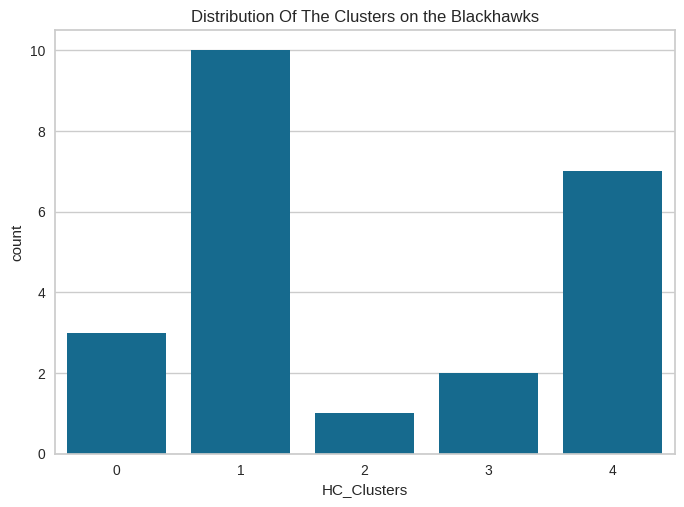

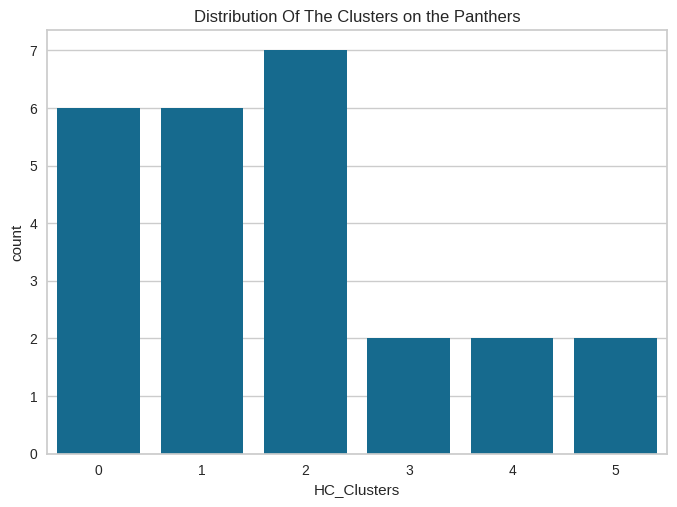

In [ ]:
#show HC_clusters for Blackhawks and then for the Florida Panthers to compare

pl = sns.countplot(x=filtered_hawks_df["HC_Clusters"])
pl.set_title("Distribution Of The Clusters on the Blackhawks")
plt.show();

pl = sns.countplot(x=filtered_panthers_df["HC_Clusters"])
pl.set_title("Distribution Of The Clusters on the Panthers")
plt.show();

In [ ]:
#show HC_clusters for Blackhawks and then for the Florida Panthers to compare

#pl = sns.countplot(x=filtered_panthers_df["HC_Clusters"])
#pl.set_title("Distribution Of The Clusters on the Panthers 2024 Stanley Cup Championship Team")
print("Distribution Of The Clusters on the Panthers 2024 Stanley Cup Championship Team")
labeled_barplot(filtered_panthers_df, "HC_Clusters", perc=True)
# Save as PNG
plt.savefig("2024ChampFLA.png", dpi=300, bbox_inches='tight')
plt.show();



Distribution Of The Clusters on the Panthers 2024 Stanley Cup Championship Team


<Figure size 800x550 with 0 Axes>

##Stanley Cup Champs from 2024
As can be seen from the chart above, the Florida Panthers had a really well balanced roster.  They had several members from each group.  Group 0 is the defenseman and important to have a number of them.  Group 1 is probably the weakest of the groups and least important, but they had some of them as well.  Group 2 is your all-stars and they had a few.  Group 3 is the depth players that are a little higher ranked than Group 4.  Group 4 is your bottom of the pack group in the NHL and Group 5 is the tough guys.  Looks like they help in the long haul for the playoffs.


## Actionable Insights and Recommendations

-

Top 4 NHL Teams in 2025 — Trade Deadline Analysis

Now we’ll look at the top four NHL teams at the time of writing to see what they need before the trade deadline.

Winnipeg Jets

<img src="/content/WPG.png" width="300">

High representation in Groups 1 & 4, with no Group 5 players.
Strong core of stars but lacking physical toughness.
Trade Recommendation: Acquire Group 5 players for playoff resilience.

Edmonton Oilers

<img src="/content/EDM.png" width="300">

Lacking depth in Group 4 and physical presence in Group 5.
Trade Recommendation: Add depth players (Group 4) and physical enforcers (Group 5).

Washington Capitals

<img src="/content/WSH.png" width="300">

Balanced roster overall.
Trade Recommendation: Consider adding Group 3 players for additional depth.

Dallas Stars

<img src="/content/DAL.png" width="300">

Well-balanced team.
Trade Recommendation: No major trades needed before the playoffs.

#Conclusion

As the NHL trade deadline approaches, teams must strategically assess their needs and utilize HC clusters and data analysis to guide their decisions. By addressing key areas such as scoring depth, defensive reinforcement, and roster depth, teams can position themselves for a successful playoff run. The integration of data-driven insights and consideration of intangibles will ultimately determine the effectiveness of trade moves and the overall success of NHL teams in their pursuit of the Stanley Cup.

